In [60]:
import numpy as np
import pandas as pd
import os
import torch
import squidpy as sq
import re
import glob
import scanpy as sc
import anndata
import torch.nn.functional as F
import scipy.stats as stats
import matplotlib as mpl
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator
from matplotlib.colors import to_rgb, to_hex

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

CELL_TYPE_COLORS = {
    'mBc1': '#E64B35',    
    'mBc2': '#4DBBD5',    
    'mBc3': '#00A087',   
    'mBc4': '#3C5488',   
    'nmBc1': '#8B00FF',   
    'nmBc2': '#A0522D',   
}


In [36]:
anno_cluster = pd.read_csv("samples/GSE203552_annotation_cluster_bc.csv", index_col=0)
anno_cluster.index.name = "barcode"

In [ ]:
adata = anndata.read_csv("samples/p1_biopsy/processed_rna.csv")
biopsy = pd.read_csv("samples/p1_biopsy/processed_bcr.csv", index_col="barcode")
common_cells = list(set(anno_cluster.index.tolist()) & set(biopsy.index.tolist()))
adata.obs.loc[common_cells, 'celltypes'] = anno_cluster.loc[common_cells].values
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, n_top_genes=5000)
#adata = adata[:, adata.var.highly_variable]
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)
adata = adata[adata.obs[adata.obs.celltypes.isin(["mBc1", "mBc2", "mBc3", "mBc4", "nmBc1", "nmBc2"])].index.tolist()]

fig, axs = plt.subplots(figsize=(6, 6), dpi=300)  # Customize the figure size as needed
sc.pl.umap(adata, color="celltypes", palette=CELL_TYPE_COLORS, ax=axs)
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_originalRNA_UMAP.pdf",  bbox_inches='tight')

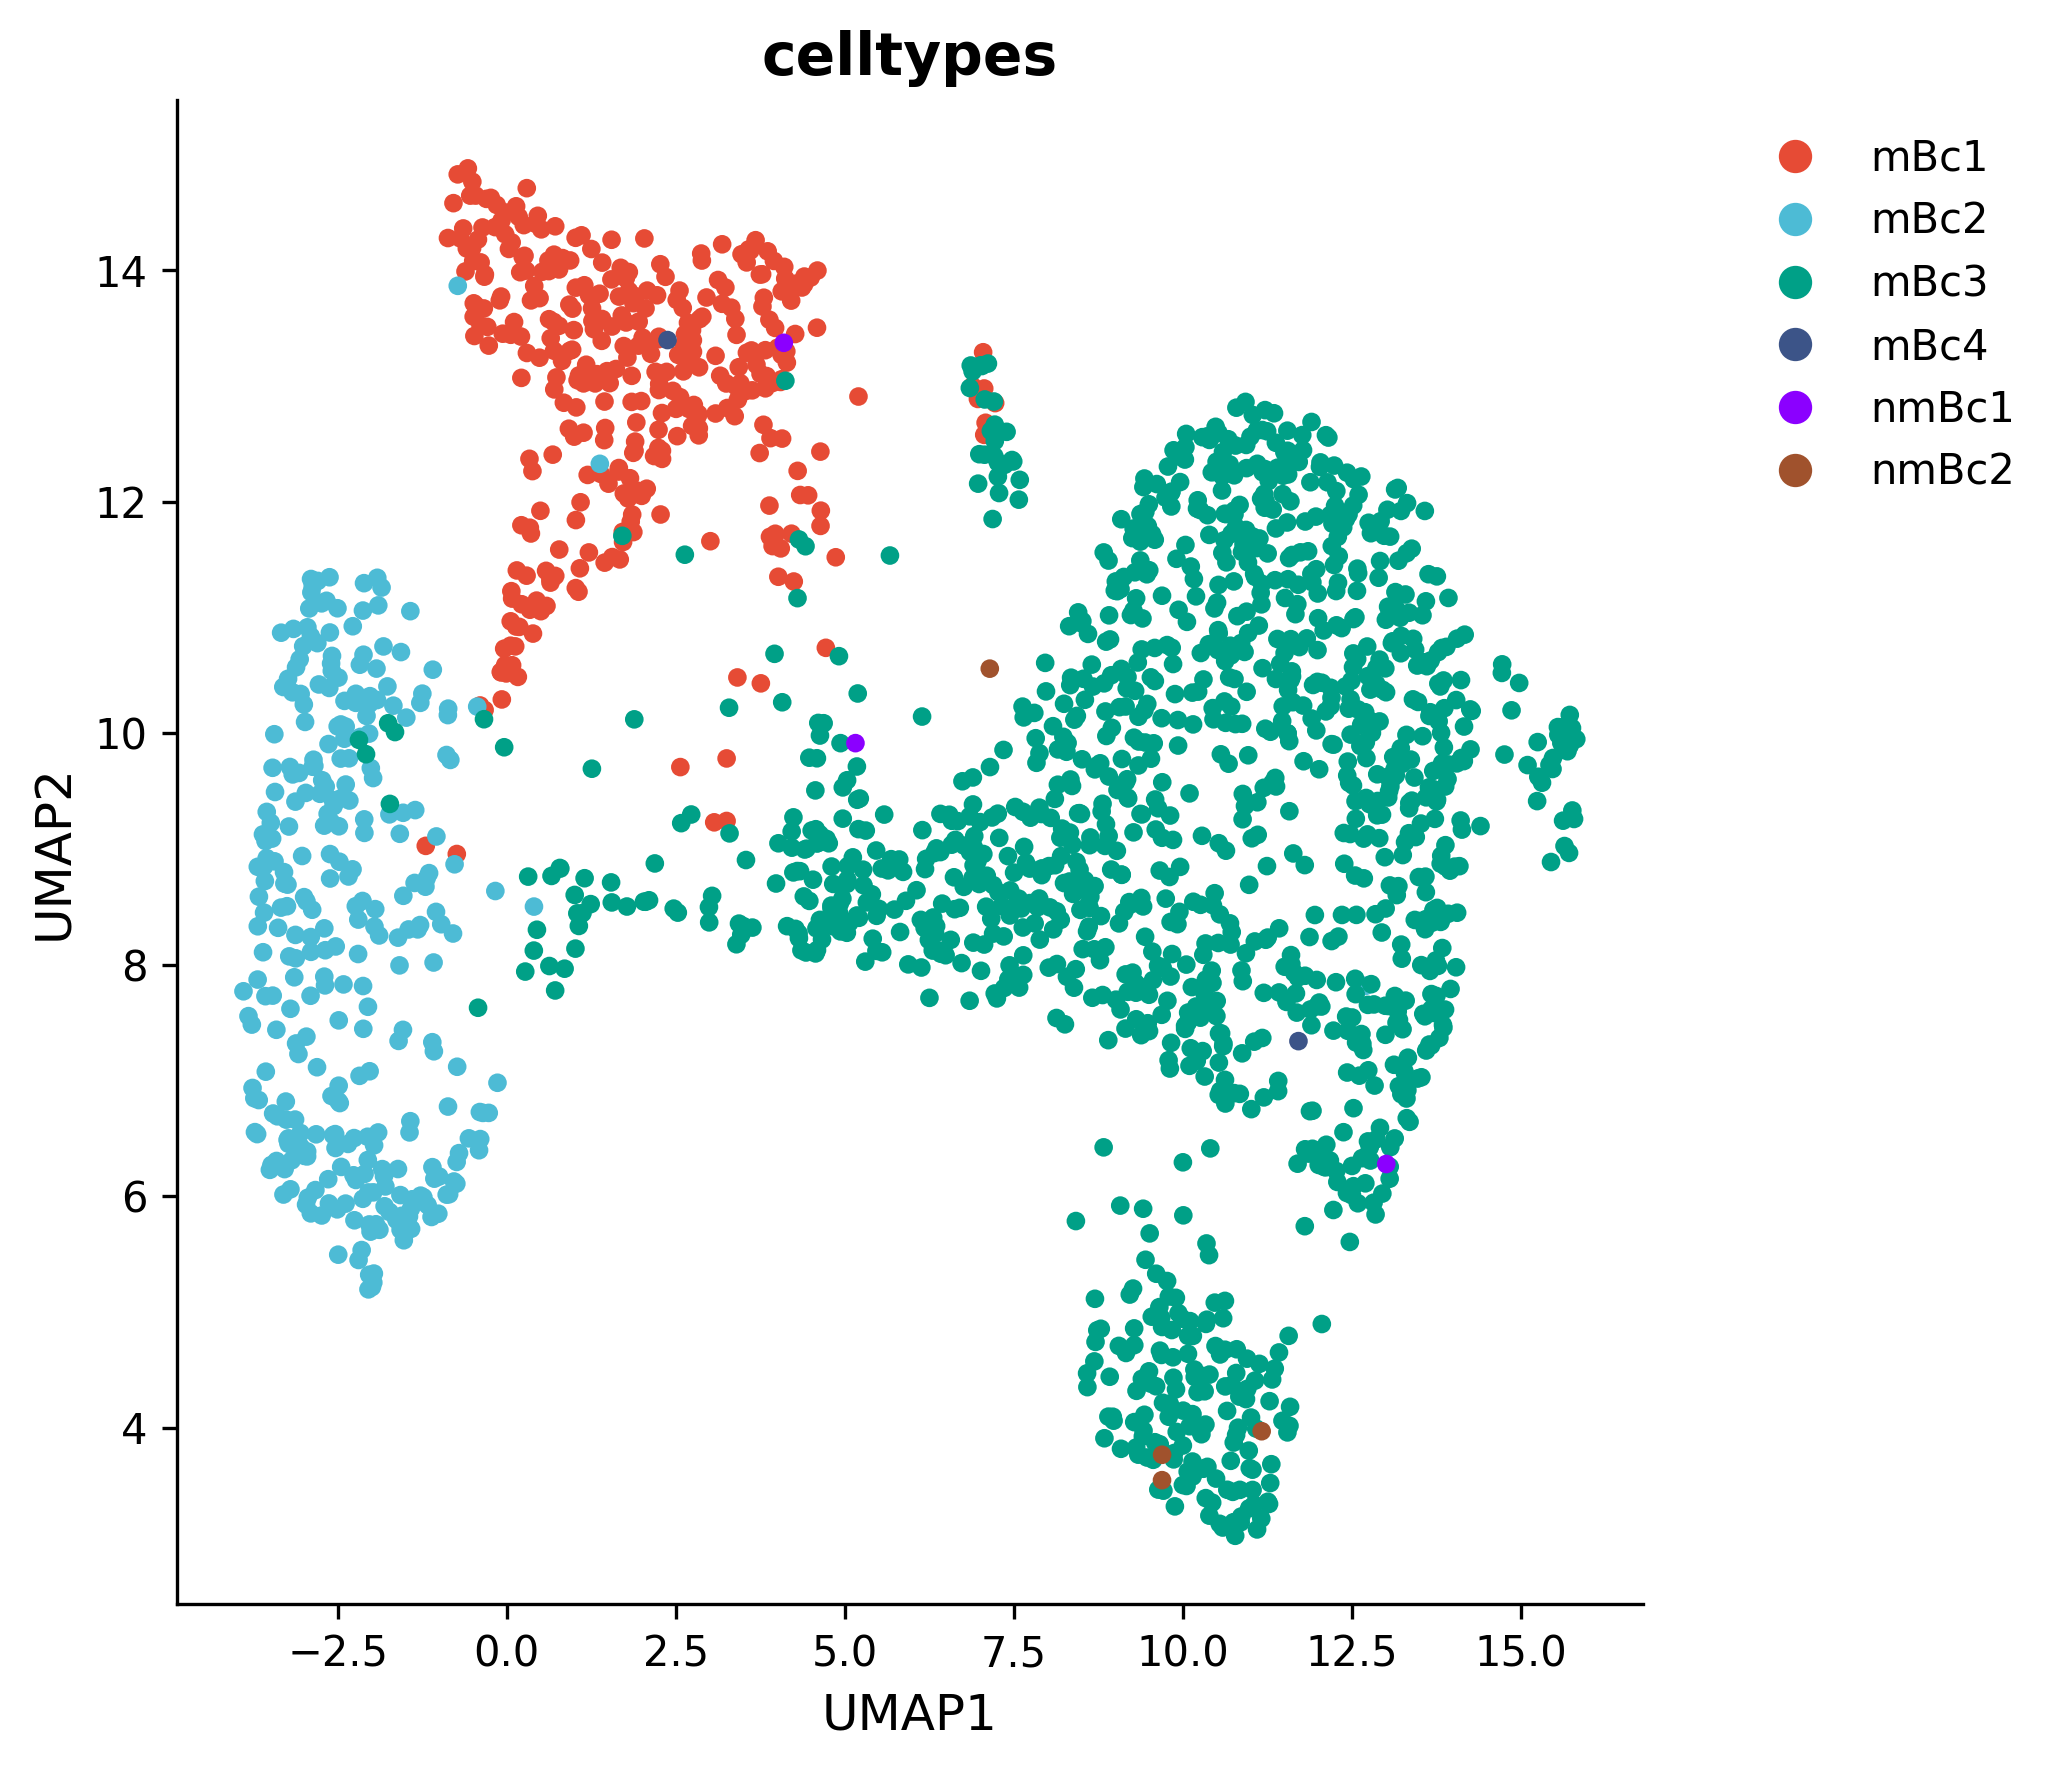

In [38]:
from matplotlib.lines import Line2D
# Define cell order and colors
cell_order = ['mBc1', 'mBc2', 'mBc3', 'mBc4', 'nmBc1', 'nmBc2']
CELL_TYPE_COLORS_ORDERED = {
    'mBc1': '#E64B35',    
    'mBc2': '#4DBBD5',    
    'mBc3': '#00A087',   
    'mBc4': '#3C5488',   
    'nmBc1': '#8B00FF',   
    'nmBc2': '#A0522D',   
}

# Set categorical order
adata.obs['celltypes'] = pd.Categorical(
    adata.obs['celltypes'], 
    categories=cell_order, 
    ordered=True
)

# Create figure
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)

# Plot each cell type in order
for celltype in cell_order:
    mask = adata.obs['celltypes'] == celltype
    coords = adata.obsm['X_umap'][mask]
    ax.scatter(
        coords[:, 0], 
        coords[:, 1],
        c=CELL_TYPE_COLORS_ORDERED[celltype],
        s=20,
        alpha=1,
        label=celltype,
        edgecolors='none'
    )

# Add legend with circular markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w', 
           markerfacecolor=CELL_TYPE_COLORS_ORDERED[ct], 
           markersize=8, 
           label=ct,
           markeredgewidth=0)
    for ct in cell_order
]

ax.legend(handles=legend_elements, 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left',
          frameon=False,
          fontsize=10)

ax.set_xlabel('UMAP1', fontsize=12)
ax.set_ylabel('UMAP2', fontsize=12)
ax.set_title('celltypes', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_originalRNA_UMAP.pdf",  bbox_inches='tight')

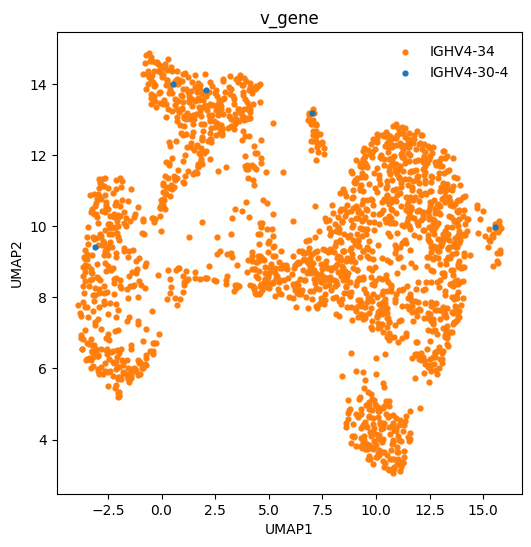

In [95]:
fig, ax = plt.subplots(figsize=(6, 6))

# 取得 UMAP 座標
umap = adata.obsm['X_umap']

# 先畫橙色（IGHV4-34）在底層
mask_34 = adata.obs['v_gene'] == 'IGHV4-34'
ax.scatter(umap[mask_34, 0], umap[mask_34, 1],
           c='#ff7f0e', s=12, label='IGHV4-34')

# 再畫藍色（IGHV4-30-4）在上層
mask_30 = adata.obs['v_gene'] == 'IGHV4-30-4'
ax.scatter(umap[mask_30, 0], umap[mask_30, 1],
           c='#1f77b4', s=12, label='IGHV4-30-4')

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('v_gene')
ax.legend(frameon=False)
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/3modalities/original_v_gene_family.pdf",  bbox_inches='tight')

/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


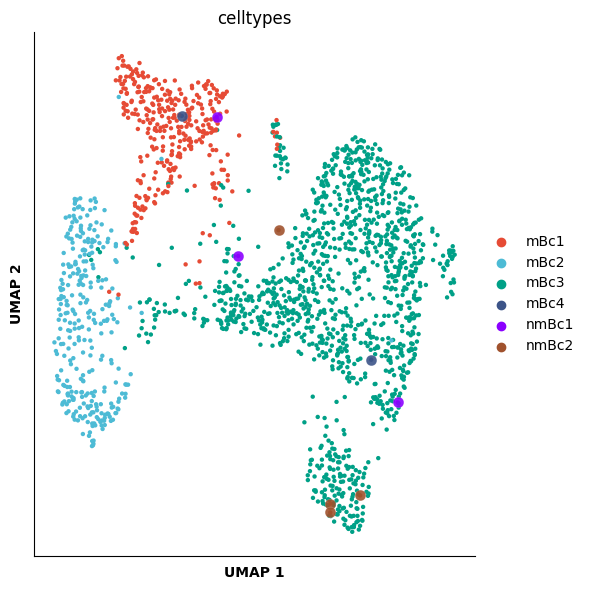

In [ ]:
# ============ Set plotting order ============
plot_order = ["mBc1", "mBc2", "mBc3", "mBc4", "nmBc1", "nmBc2"]
adata.obs['celltypes'] = pd.Categorical(
    adata.obs['celltypes'], 
    categories=plot_order, 
    ordered=True
)

# Set colors in uns
adata.uns['celltypes_colors'] = [CELL_TYPE_COLORS[ct] for ct in plot_order]

# ============ Create figure ============
fig, axs = plt.subplots(figsize=(6, 6))

# ============ First plot all cells (small dots) ============
sc.pl.umap(
    adata, 
    color="celltypes", 
    ax=axs,
    size=40,
    show=False,
    legend_loc='right margin',
    frameon=True
)

# ============ Get UMAP coordinates ============
umap_coords = adata.obsm['X_umap']

# ============ Highlight mBc4 (dark blue large dots) ============
mbc4_mask = adata.obs['celltypes'] == 'mBc4'
axs.scatter(
    umap_coords[mbc4_mask, 0], 
    umap_coords[mbc4_mask, 1],
    s=60,  # Large dots
    c=CELL_TYPE_COLORS['mBc4'],  # Dark blue
    edgecolors='white',
    linewidths=0.1,
    alpha=0.9,
    zorder=10  # Ensure on top layer
)

# ============ Highlight nmBc1 (purple large dots) ============
nmbc1_mask = adata.obs['celltypes'] == 'nmBc1'
axs.scatter(
    umap_coords[nmbc1_mask, 0], 
    umap_coords[nmbc1_mask, 1],
    s=60,  # Large dots
    c=CELL_TYPE_COLORS['nmBc1'],  # Purple
    edgecolors='white',
    linewidths=0.1,
    alpha=0.9,
    zorder=10
)

# ============ Highlight nmBc2 (brown large dots) ============
nmbc2_mask = adata.obs['celltypes'] == 'nmBc2'
axs.scatter(
    umap_coords[nmbc2_mask, 0], 
    umap_coords[nmbc2_mask, 1],
    s=60,  # Large dots
    c=CELL_TYPE_COLORS['nmBc2'],  # Brown
    edgecolors='white',
    linewidths=0.1,
    alpha=0.9,
    zorder=10
)

# ============ Adjust style ============
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_xlabel('UMAP 1', fontsize=10, fontweight='bold')
axs.set_ylabel('UMAP 2', fontsize=10, fontweight='bold')

plt.tight_layout()

# ============ Save figure ============
fig.savefig(
    "/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_originalRNA_UMAP2.pdf",  
    bbox_inches='tight',
)


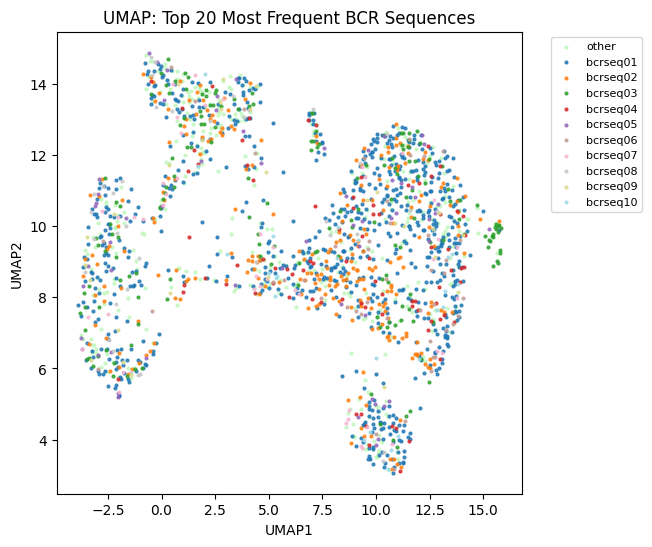

In [ ]:
adata.obs.loc[new_adata.obs.index, 'bcr_top10'] = new_adata.obs['bcr_top10']
# Plot
fig, axs = plt.subplots(figsize=(6, 6))
coords = adata.obsm['X_umap']
labels = adata.obs['bcr_top10']

# Colors
unique_labels = sorted([l for l in labels.unique() if l != 'other'])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# Plot background (other)
mask = labels == 'other'
axs.scatter(coords[mask, 0], coords[mask, 1], c='#C1F8BE', s=4, alpha=0.8, label='other')

# Plot top sequences
for i, label in enumerate(unique_labels):
    mask = labels == label
    axs.scatter(coords[mask, 0], coords[mask, 1], c=[colors[i]], s=4, alpha=0.8, label=label)

axs.set_xlabel('UMAP1')
axs.set_ylabel('UMAP2')
axs.set_title('UMAP: Top 10 Most Frequent BCR Sequences')
axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/3modalities/originalgex_top10_simple.pdf", bbox_inches='tight')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


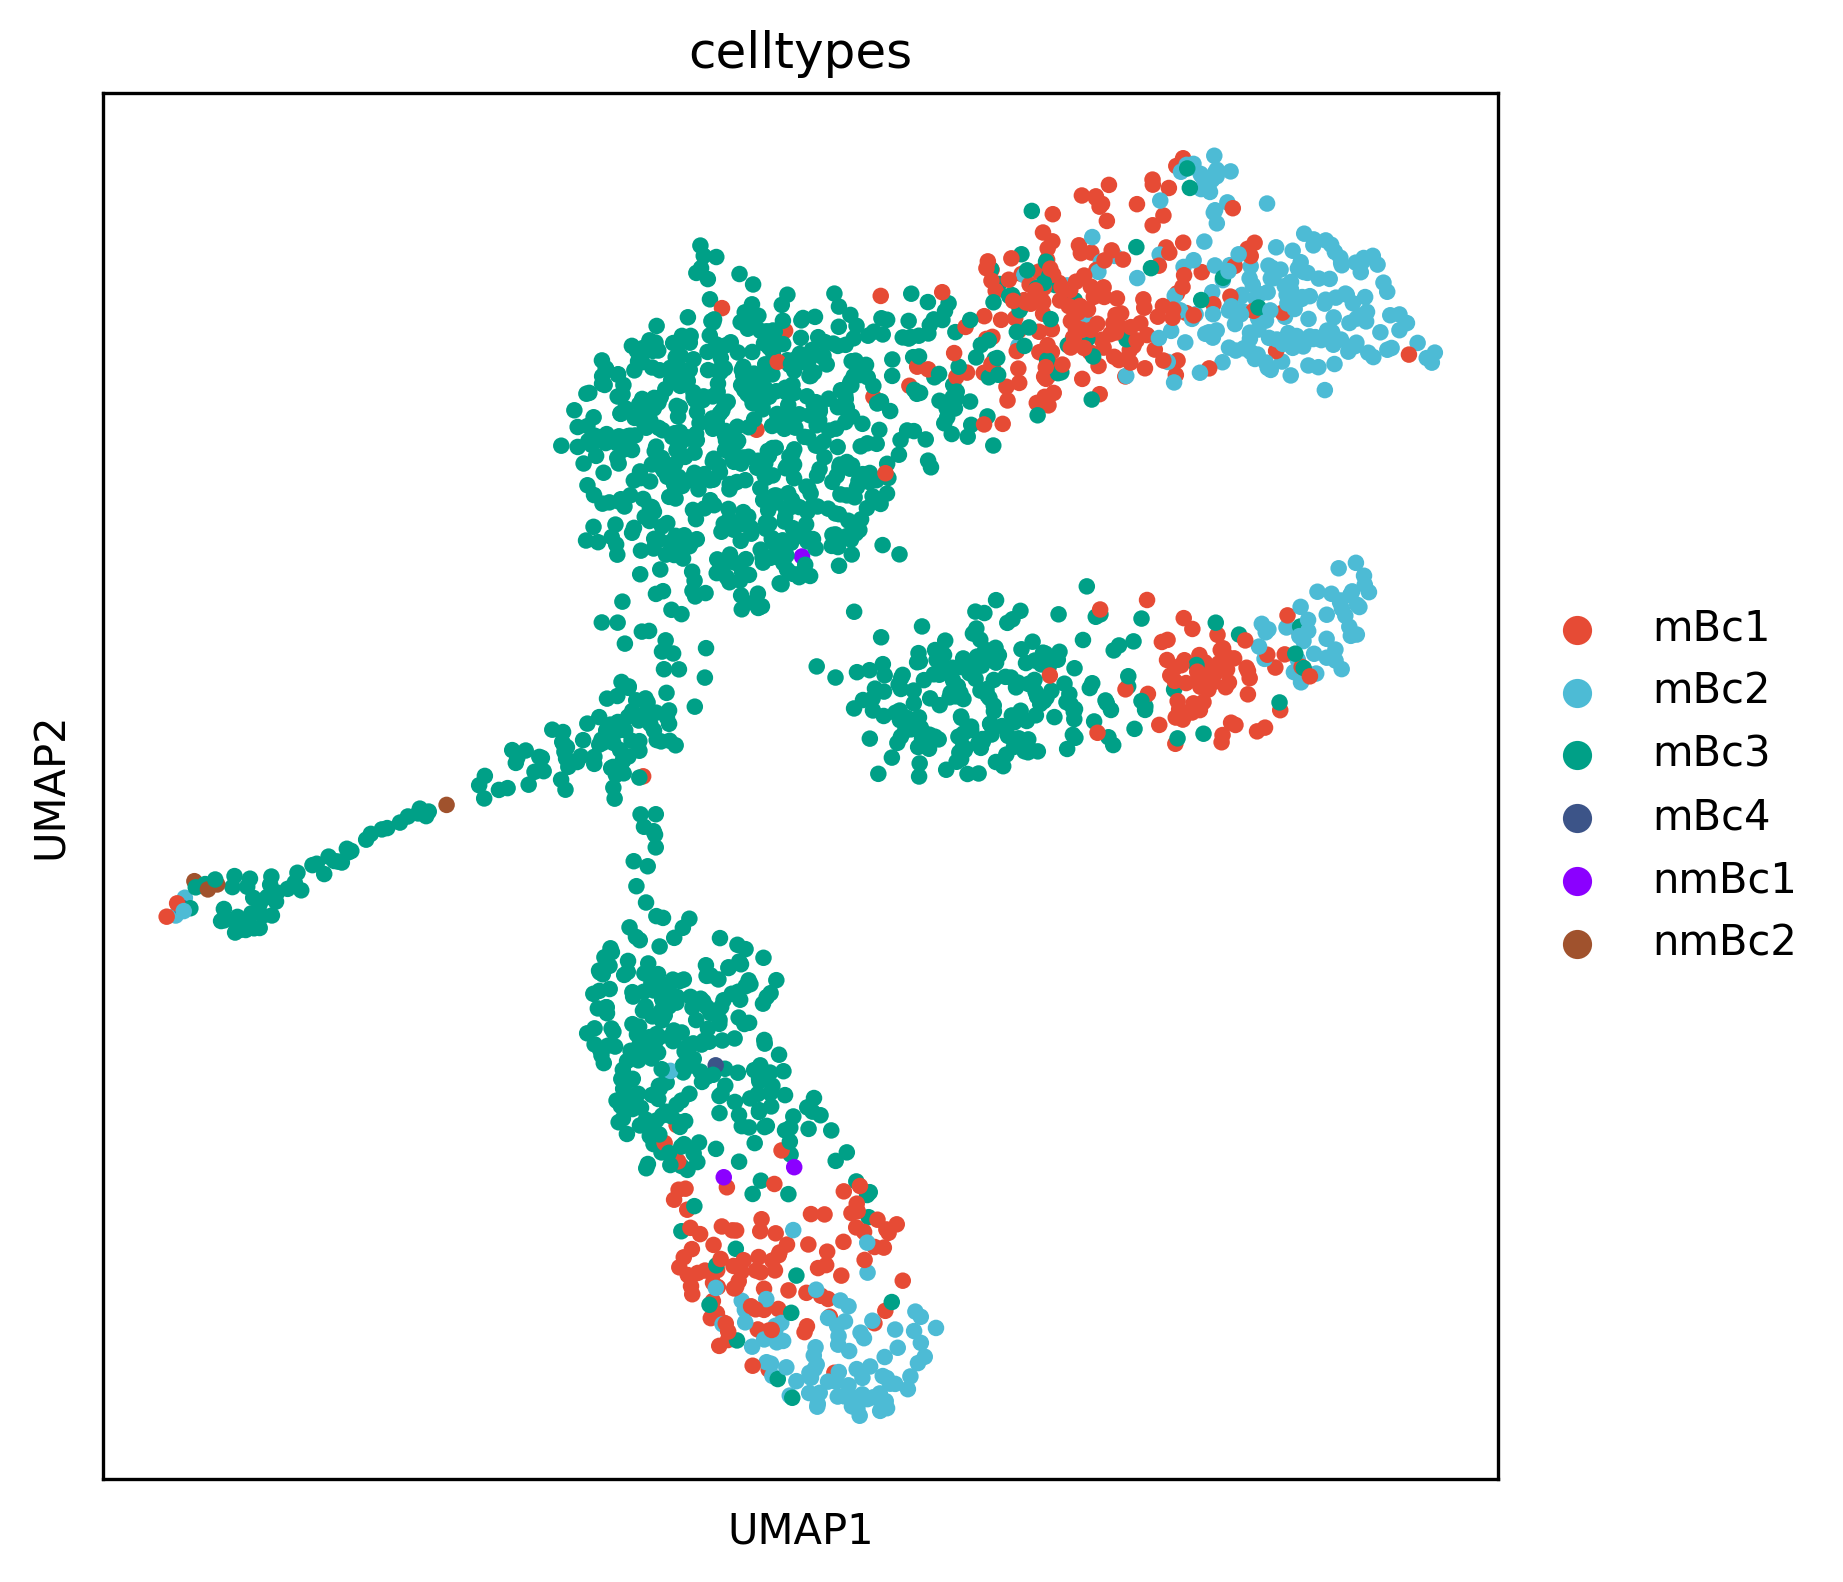

In [2]:
bcrtype = pd.read_csv("samples/GSE203552_annotation_cluster_bc.csv", index_col=0)
bcrtype.index.name = "barcode"

biopsy = pd.read_csv("samples/p1_biopsy/processed_bcr.csv", index_col="barcode")
bcremb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/CNS_GSE203552/p1_biopsy/mean_inner01.pth/embedding.csv").values
gexemb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/CNS_GSE203552/p1_biopsy/mean_inner01.pth/gexembedding.csv").values
datapath = "/mnt/d/BCRdataset/CNS_GSE203552/samples/p1_biopsy"
bcrfile_path = os.path.join(datapath, "processed_bcr.csv")
bcrfile = pd.read_csv(bcrfile_path, index_col="barcode")
bcrfile['whole_seq'] = bcrfile['fwr1'].str.cat([bcrfile["cdr1"], bcrfile["fwr2"], bcrfile["cdr2"], bcrfile["fwr3"],
                                               bcrfile["cdr3"], bcrfile["fwr4"]])
embeddings = np.concatenate([bcremb, gexemb], axis=1)
embeddings = torch.from_numpy(embeddings)
embeddings = F.normalize(embeddings, dim = -1).numpy()


new_adata = anndata.AnnData(embeddings)
new_adata.obs['barcode'] = bcrfile.index.tolist()
new_adata.obs = new_adata.obs.set_index('barcode', inplace=False)
new_adata.obs['cdr3'] = bcrfile.cdr3.tolist()
new_adata.obs['v_gene'] = bcrfile.v_gene.tolist()
new_adata.obs['whole_seq'] = bcrfile.whole_seq.tolist()
new_adata.obs.loc[bcrfile.index.tolist(), 'whole_seq'] = bcrfile['whole_seq']
new_adata.obs.loc[bcrfile.index.tolist(), 'v_gene'] = bcrfile['v_gene']
new_adata.obs.loc[bcrfile.index.tolist(), 'j_gene'] = bcrfile['j_gene']
new_adata.obs.loc[bcrfile.index.tolist(), 'c_gene'] = bcrfile['c_gene']
new_adata.obs['v_gene_family'] = new_adata.obs['v_gene'].str.split('/').str[0].str.extract(r'(IGH[VDJ]\d+)')[0]
new_adata.obs['j_gene_family'] = new_adata.obs['j_gene'].str.split('/').str[0].str.extract(r'(IGH[VDJ]\d+)')[0]
seq_counts = new_adata.obs['whole_seq'].value_counts()
seq_to_id = {seq: f'bcrseq{i+1}' for i, seq in enumerate(seq_counts.index)}
new_adata.obs['whole_seq_label'] = new_adata.obs['whole_seq'].map(seq_to_id)
top20_labels = new_adata.obs['whole_seq_label'].value_counts().head(10).index.tolist()
new_adata.obs['whole_seq_top20'] = new_adata.obs['whole_seq_label'].apply(
    lambda x: x if x in top20_labels else 'Others'
)
common_cells = list(set(bcrtype.index.tolist()) & set(bcrfile.index.tolist()))
new_adata.obs.loc[common_cells, 'celltypes'] = bcrtype.loc[common_cells].values
new_adata = new_adata[new_adata.obs[new_adata.obs.celltypes.isin(["mBc1", "mBc2", "mBc3", "mBc4", "nmBc1", "nmBc2"])].index.tolist()]
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(new_adata)

cell_order = ['mBc1', 'mBc2', 'mBc3', 'mBc4', 'nmBc1', 'nmBc2']
new_adata.obs['celltypes'] = pd.Categorical(
    new_adata.obs['celltypes'], 
    categories=cell_order, 
    ordered=True
)
fig, axs = plt.subplots(figsize=(6, 6), dpi=300)  # Customize the figure size as needed
sc.pl.umap(new_adata, color="celltypes", palette=CELL_TYPE_COLORS, ax=axs)
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_embedding_UMAP.pdf",  bbox_inches='tight')

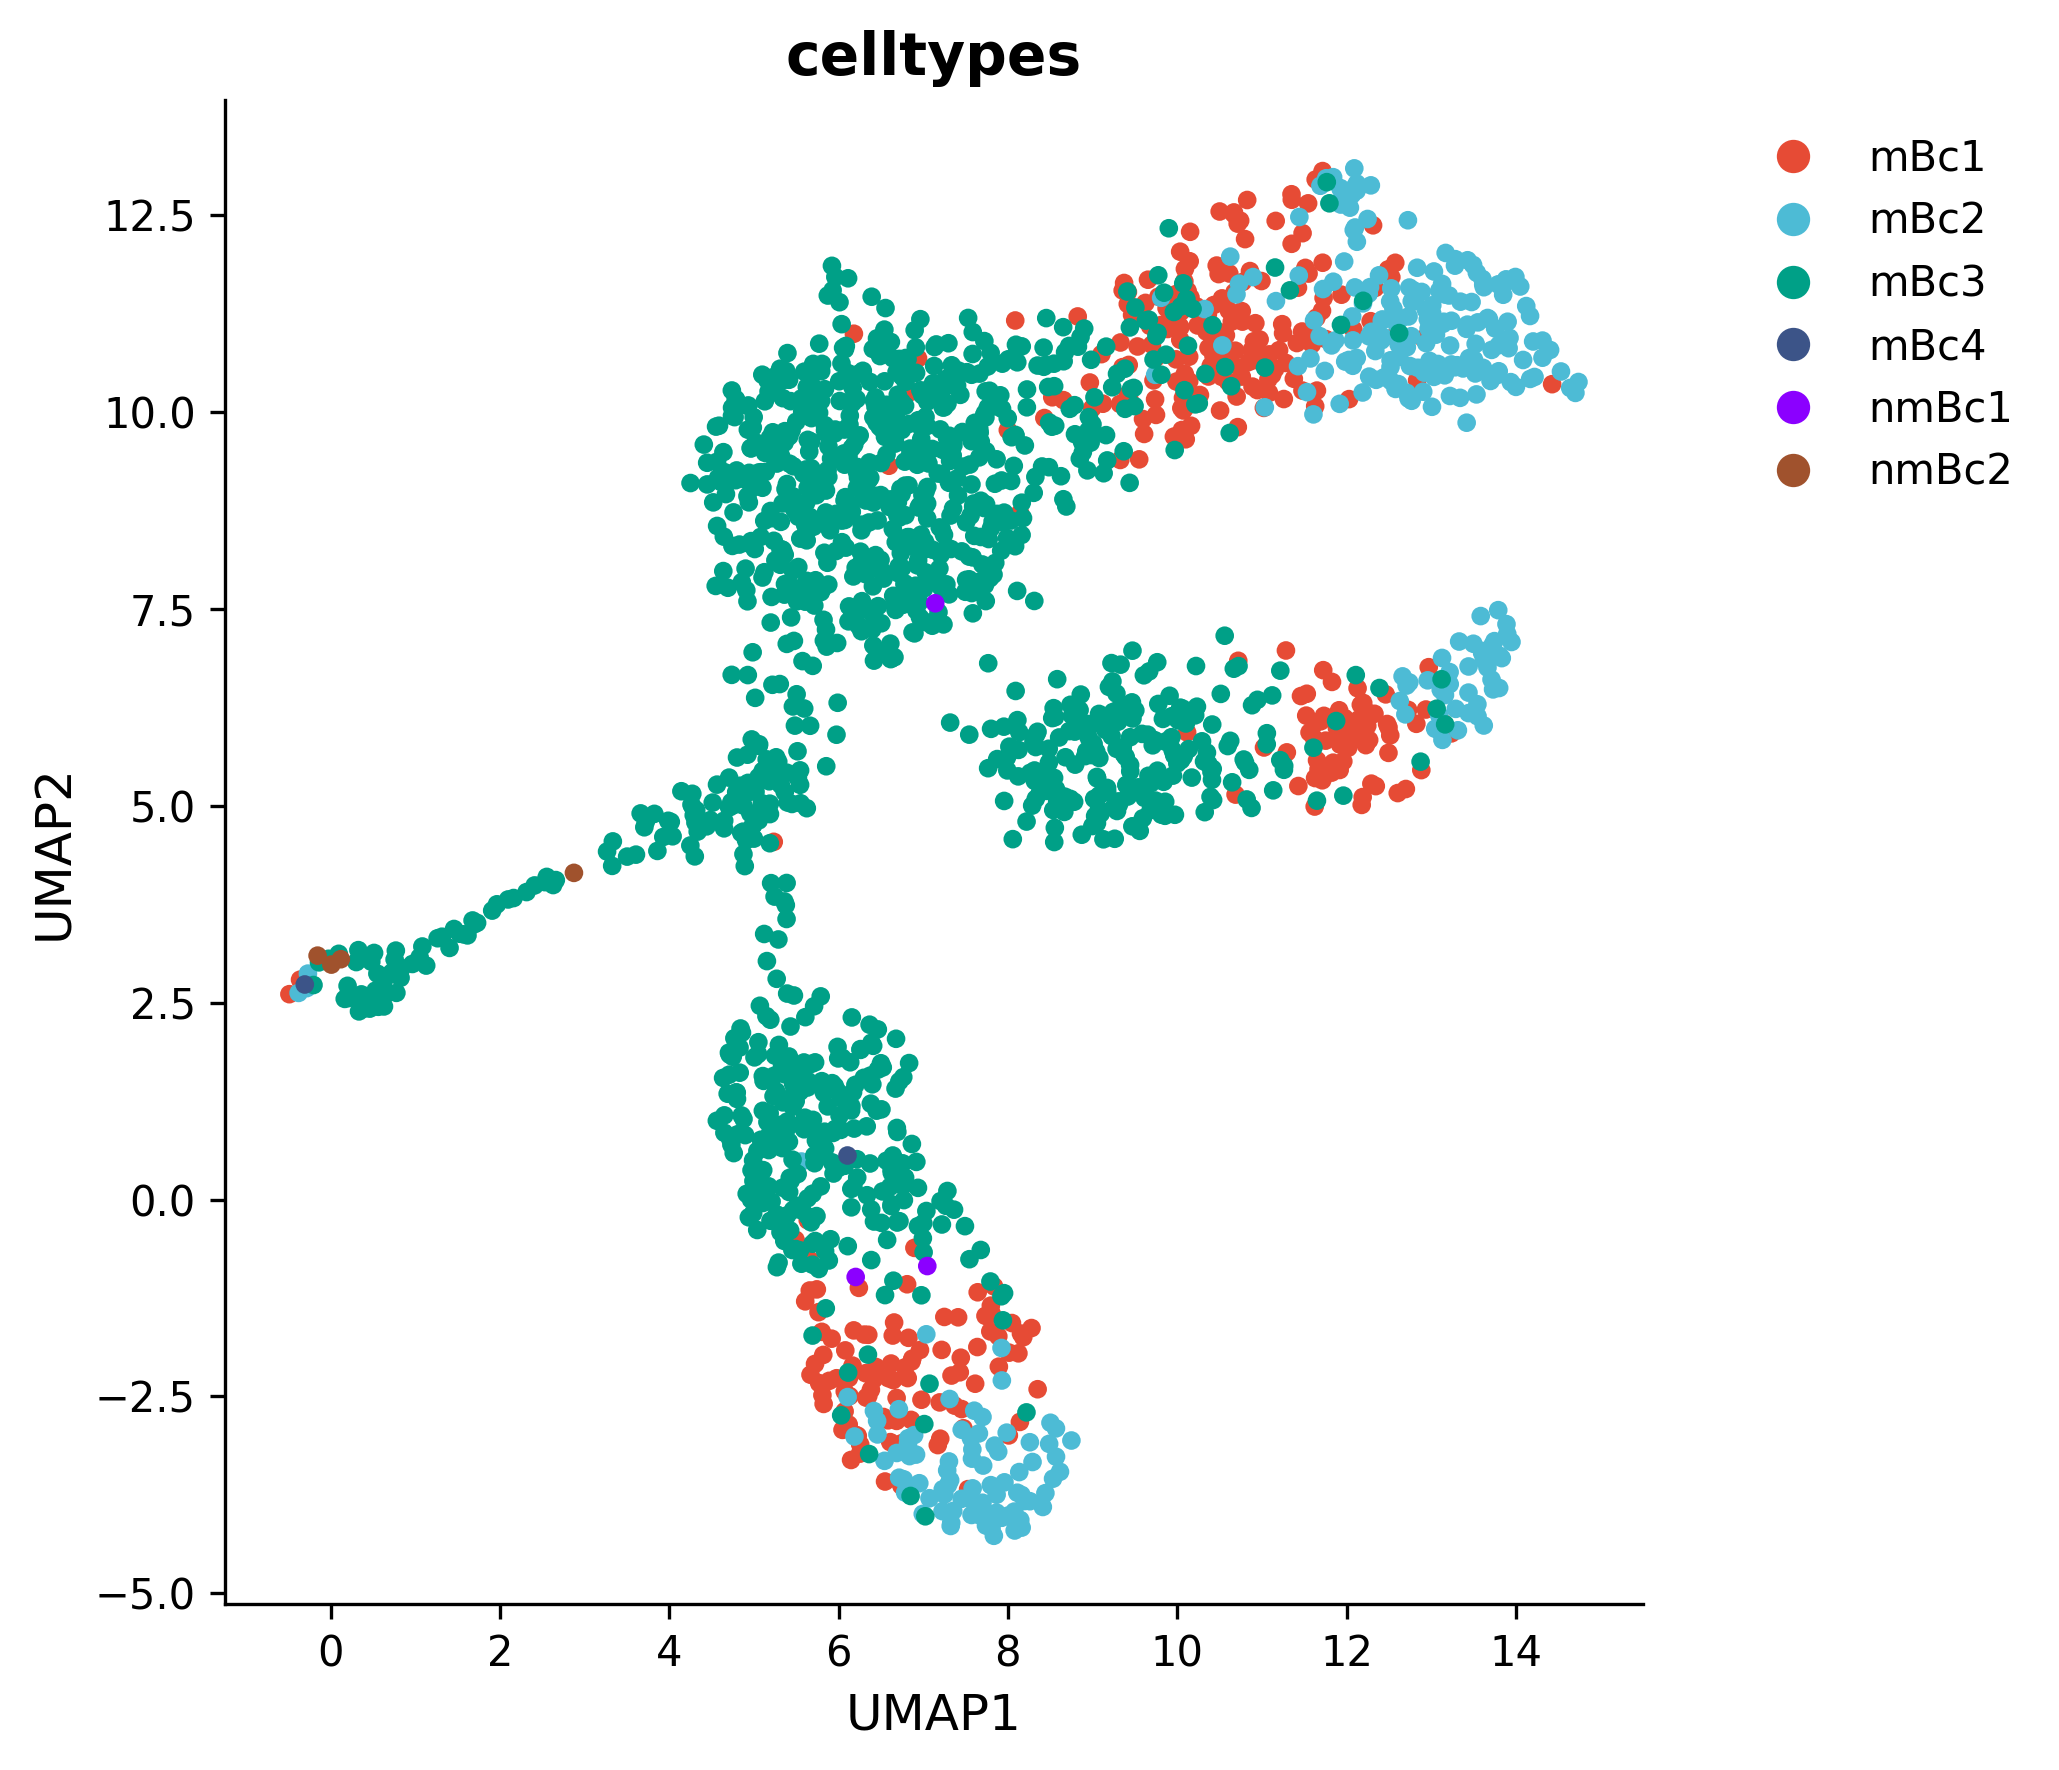

In [33]:
from matplotlib.lines import Line2D
# Define cell order and colors
cell_order = ['mBc1', 'mBc2', 'mBc3', 'mBc4', 'nmBc1', 'nmBc2']
CELL_TYPE_COLORS_ORDERED = {
    'mBc1': '#E64B35',    
    'mBc2': '#4DBBD5',    
    'mBc3': '#00A087',   
    'mBc4': '#3C5488',   
    'nmBc1': '#8B00FF',   
    'nmBc2': '#A0522D',   
}

# Set categorical order
new_adata.obs['celltypes'] = pd.Categorical(
    new_adata.obs['celltypes'], 
    categories=cell_order, 
    ordered=True
)

# Create figure
fig, ax = plt.subplots(figsize=(7, 6), dpi=300)

# Plot each cell type in order
for celltype in cell_order:
    mask = new_adata.obs['celltypes'] == celltype
    coords = new_adata.obsm['X_umap'][mask]
    ax.scatter(
        coords[:, 0], 
        coords[:, 1],
        c=CELL_TYPE_COLORS_ORDERED[celltype],
        s=20,
        alpha=1,
        label=celltype,
        edgecolors='none'
    )

# Add legend with circular markers
legend_elements = [
    Line2D([0], [0], marker='o', color='w', 
           markerfacecolor=CELL_TYPE_COLORS_ORDERED[ct], 
           markersize=8, 
           label=ct,
           markeredgewidth=0)
    for ct in cell_order
]

ax.legend(handles=legend_elements, 
          bbox_to_anchor=(1.05, 1), 
          loc='upper left',
          frameon=False,
          fontsize=10)

ax.set_xlabel('UMAP1', fontsize=12)
ax.set_ylabel('UMAP2', fontsize=12)
ax.set_title('celltypes', fontsize=14, fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_embedding_UMAP.pdf",  bbox_inches='tight')

/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


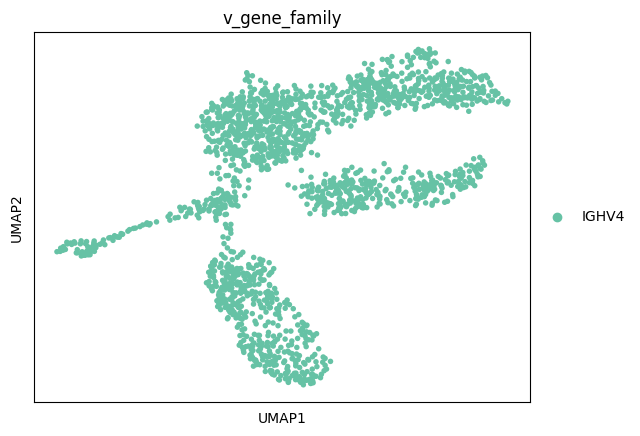

In [51]:
sc.pl.umap(new_adata, color="v_gene_family", palette='Set2', show=False)
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/3modalities/combcr_v_gene_family.pdf",  bbox_inches='tight')

/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


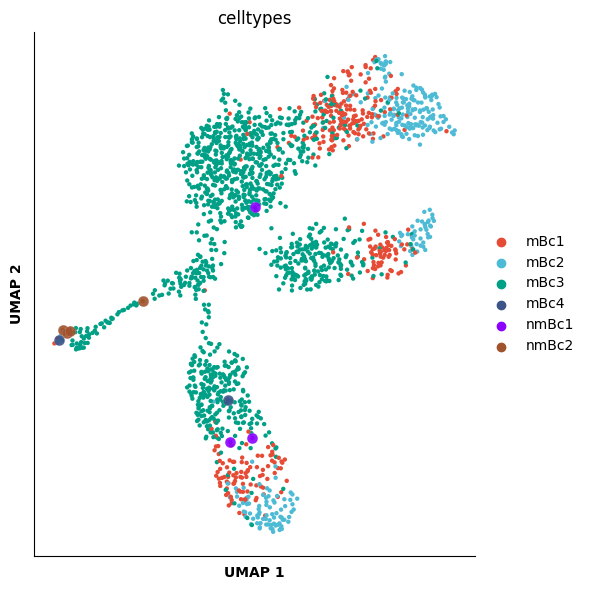

In [ ]:
# ============ Set plotting order ============
plot_order = ["mBc1", "mBc2", "mBc3", "mBc4", "nmBc1", "nmBc2"]
new_adata.obs['celltypes'] = pd.Categorical(
    new_adata.obs['celltypes'], 
    categories=plot_order, 
    ordered=True
)

# Set colors in uns
new_adata.uns['celltypes_colors'] = [CELL_TYPE_COLORS[ct] for ct in plot_order]

# ============ Create figure ============
fig, axs = plt.subplots(figsize=(6, 6))

# ============ First plot all cells (small dots) ============
sc.pl.umap(
    new_adata, 
    color="celltypes", 
    ax=axs,
    size=40,
    show=False,
    legend_loc='right margin',
    frameon=True
)

# ============ Get UMAP coordinates ============
umap_coords = new_adata.obsm['X_umap']

# ============ Highlight mBc4 (dark blue large dots) ============
mbc4_mask = new_adata.obs['celltypes'] == 'mBc4'
axs.scatter(
    umap_coords[mbc4_mask, 0], 
    umap_coords[mbc4_mask, 1],
    s=60,  # Large dots
    c=CELL_TYPE_COLORS['mBc4'],  # Dark blue
    edgecolors='white',
    linewidths=0.1,
    alpha=0.9,
    zorder=10  # Ensure on top layer
)

# ============ Highlight nmBc1 (purple large dots) ============
nmbc1_mask = new_adata.obs['celltypes'] == 'nmBc1'
axs.scatter(
    umap_coords[nmbc1_mask, 0], 
    umap_coords[nmbc1_mask, 1],
    s=60,  # Large dots
    c=CELL_TYPE_COLORS['nmBc1'],  # Purple
    edgecolors='white',
    linewidths=0.1,
    alpha=0.9,
    zorder=10
)

# ============ Highlight nmBc2 (brown large dots) ============
nmbc2_mask = new_adata.obs['celltypes'] == 'nmBc2'
axs.scatter(
    umap_coords[nmbc2_mask, 0], 
    umap_coords[nmbc2_mask, 1],
    s=60,  # Large dots
    c=CELL_TYPE_COLORS['nmBc2'],  # Brown
    edgecolors='white',
    linewidths=0.1,
    alpha=0.9,
    zorder=10
)

# ============ Adjust style ============
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_xlabel('UMAP 1', fontsize=10, fontweight='bold')
axs.set_ylabel('UMAP 2', fontsize=10, fontweight='bold')

plt.tight_layout()

# ============ Save figure ============
fig.savefig(
    "/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_embedding_UMAP2.pdf",  
    bbox_inches='tight',
)

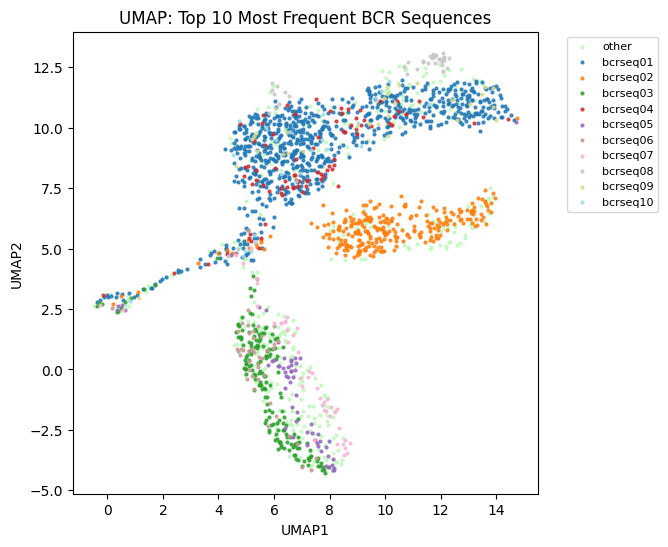

In [ ]:
# Get top 10 most frequent sequences
seq_counts = new_adata.obs['whole_seq'].value_counts()
top_seqs = seq_counts.head(10).index.tolist()

# Create labels: top 10 get names, others become 'other'
seq_mapping = {}
for i, seq in enumerate(top_seqs):
    seq_mapping[seq] = f'bcrseq{i+1:02d}'

new_adata.obs['bcr_top10'] = new_adata.obs['whole_seq'].map(seq_mapping).fillna('other')

# Plot
fig, axs = plt.subplots(figsize=(6, 6))
coords = new_adata.obsm['X_umap']
labels = new_adata.obs['bcr_top10']

# Colors
unique_labels = sorted([l for l in labels.unique() if l != 'other'])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# Plot background (other)
mask = labels == 'other'
axs.scatter(coords[mask, 0], coords[mask, 1], c="#C1F8BE", s=4, alpha=0.8, label='other')

# Plot top sequences
for i, label in enumerate(unique_labels):
    mask = labels == label
    axs.scatter(coords[mask, 0], coords[mask, 1], c=[colors[i]], s=4, alpha=0.8, label=label)

axs.set_xlabel('UMAP1')
axs.set_ylabel('UMAP2')
axs.set_title('UMAP: Top 10 Most Frequent BCR Sequences')
axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/3branches/combcr_emb_top10_simple.pdf", bbox_inches='tight')


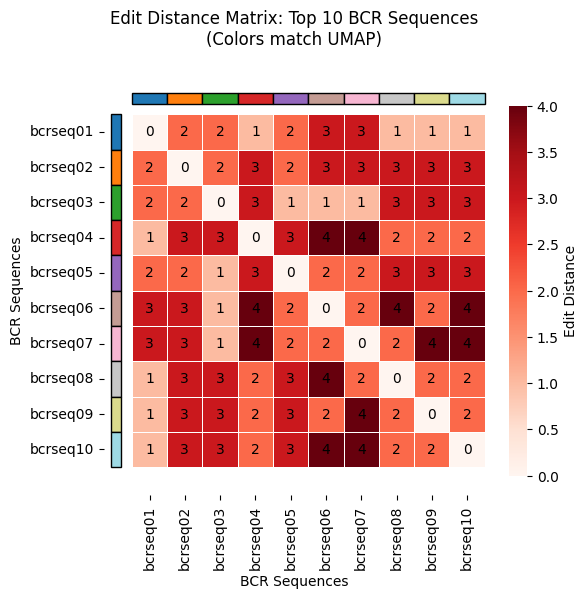

In [79]:
import seaborn as sns
from Levenshtein import distance as levenshtein_distance

# Simplified version - using white to dark red gradient
fig, ax = plt.subplots(figsize=(6, 6))

# Use the same color system as UMAP
seq_counts = new_adata.obs['whole_seq'].value_counts()
top_10_seqs = seq_counts.head(10).index.tolist()

# Create the same labels and color mapping as UMAP
top_10_labels = [f'bcrseq{i+1:02d}' for i in range(10)]
umap_colors = plt.cm.tab20(np.linspace(0, 1, 10))  # Complete 20-color mapping
top_10_colors = umap_colors[:10]  # Take first 10 colors

# Calculate edit distance matrix
n_seqs = 10
distance_matrix = np.zeros((n_seqs, n_seqs))
for i in range(n_seqs):
    for j in range(n_seqs):
        if i == j:
            distance_matrix[i, j] = 0
        else:
            dist = levenshtein_distance(top_10_seqs[i], top_10_seqs[j])
            distance_matrix[i, j] = dist

# Create DataFrame
distance_df = pd.DataFrame(distance_matrix, 
                          index=top_10_labels, 
                          columns=top_10_labels)

# Plot heatmap - using white to dark red gradient (Reds colormap)
sns.heatmap(distance_df, annot=True, fmt='.0f', 
            cmap='Reds',  # White to dark red gradient
            square=True, linewidths=0.5,
            cbar_kws={"shrink": .8, "label": "Edit Distance"},
            annot_kws={"color": "black"},
            ax=ax)

# Add color markers - both left side and bottom
for i, color in enumerate(top_10_colors):
    # Left side color bar
    rect_left = plt.Rectangle((-0.6, i), 0.3, 1, facecolor=color, 
                             edgecolor='black', linewidth=1, clip_on=False)
    ax.add_patch(rect_left)
    
    # Bottom color bar
    rect_bottom = plt.Rectangle((i, -0.6), 1, 0.3, facecolor=color, 
                               edgecolor='black', linewidth=1, clip_on=False)
    ax.add_patch(rect_bottom)

ax.set_title('Edit Distance Matrix: Top 10 BCR Sequences\n(Colors match UMAP)', 
             fontsize=12, pad=30)
ax.set_xlabel('BCR Sequences')
ax.set_ylabel('BCR Sequences')

# Adjust axis range to show color bars
ax.set_xlim(-0.8, 10)
ax.set_ylim(10.8, -0.8)

plt.tight_layout()
plt.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/3branches/edit_distance_heatmap.pdf", 
            bbox_inches='tight')
plt.show()


In [39]:
datapath = "/mnt/d/BCRdataset/CNS_GSE203552/samples/p1_biopsy"
antiberta2 = pd.read_csv(os.path.join(datapath, 'antiberta2', 'antiberta_CSSP_embedding.csv'), index_col="barcode")
antiberta2 = antiberta2.loc[new_adata.obs.index]
antiberta2 = anndata.AnnData(antiberta2.values)
antiberta2.obs = new_adata.obs
sc.pp.neighbors(antiberta2, n_neighbors=10, n_pcs=30)
sc.tl.umap(antiberta2)
#sc.pl.umap(antiberta2, color='celltypes', show=False)
#plt.savefig(f"/mnt/d/unifiedBCR/figures/CNS_GSE203552/3modalities/antiberta2_celltypes.pdf", bbox_inches='tight')

         Falling back to preprocessing with `sc.pp.pca` and default params.


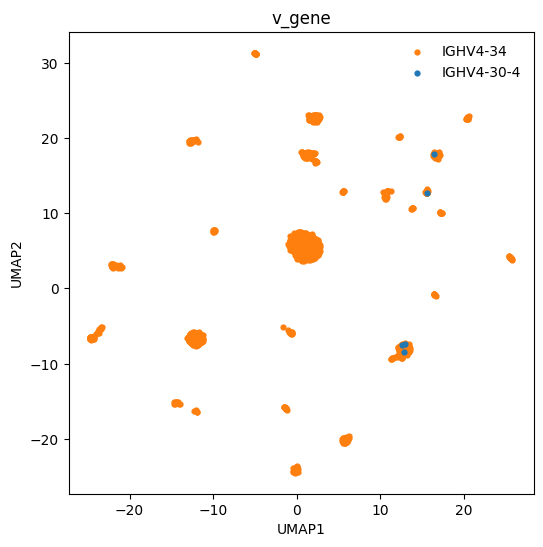

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6, 6))

# Get UMAP coordinates
umap = antiberta2.obsm['X_umap']

# First plot orange (IGHV4-34) in bottom layer
mask_34 = antiberta2.obs['v_gene'] == 'IGHV4-34'
ax.scatter(umap[mask_34, 0], umap[mask_34, 1],
           c='#ff7f0e', s=12, label='IGHV4-34')

# Then plot blue (IGHV4-30-4) in top layer
mask_30 = antiberta2.obs['v_gene'] == 'IGHV4-30-4'
ax.scatter(umap[mask_30, 0], umap[mask_30, 1],
           c='#1f77b4', s=12, label='IGHV4-30-4')

ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_title('v_gene')
ax.legend(frameon=False)
plt.savefig(f"/mnt/d/unifiedBCR/figures/CNS_GSE203552/3modalities/antiberta2_v_gene.pdf", bbox_inches='tight')


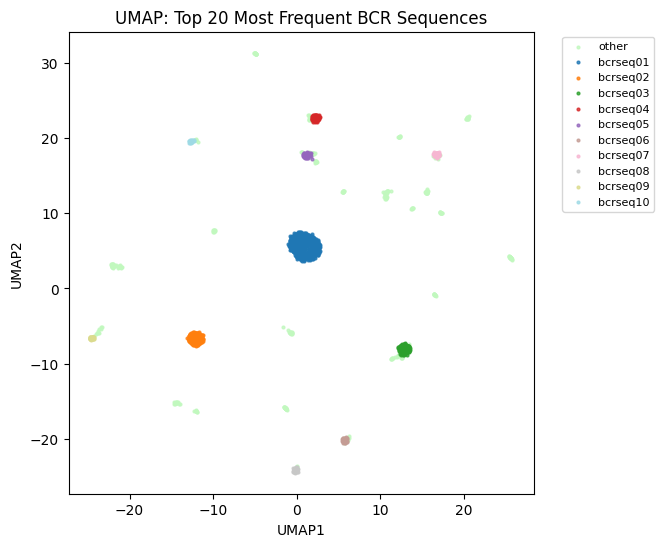

In [83]:

# Plot
fig, axs = plt.subplots(figsize=(6, 6))
coords = antiberta2.obsm['X_umap']
labels = antiberta2.obs['bcr_top10']

# Colors
unique_labels = sorted([l for l in labels.unique() if l != 'other'])
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))

# Plot background (other)
mask = labels == 'other'
axs.scatter(coords[mask, 0], coords[mask, 1], c='#C1F8BE', s=4, alpha=0.8, label='other')

# Plot top sequences
for i, label in enumerate(unique_labels):
    mask = labels == label
    axs.scatter(coords[mask, 0], coords[mask, 1], c=[colors[i]], s=4, alpha=0.8, label=label)

axs.set_xlabel('UMAP1')
axs.set_ylabel('UMAP2')
axs.set_title('UMAP: Top 20 Most Frequent BCR Sequences')
axs.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/3modalities/antiberta2_top10_simple.pdf", bbox_inches='tight')

In [6]:
new_adata.obs.head()

,cdr3,celltypes
barcode,,
AAACCTGCAGGATTGG-1_p1_biopsy1,CARGSRLKGAIFFDFW,mBc3
AAACCTGCAGTCACTA-1_p1_biopsy1,CARGSRLKGAIFFDFW,mBc3
AAACGGGAGACCACGA-1_p1_biopsy1,CARGSRLKGAIFFDFW,mBc3
AAACGGGAGTGCGATG-1_p1_biopsy1,CARGSRLKGAIFFDFW,mBc2
AAAGATGCAAGCTGTT-1_p1_biopsy1,CARGSRLKGAIFFDFW,mBc2


/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


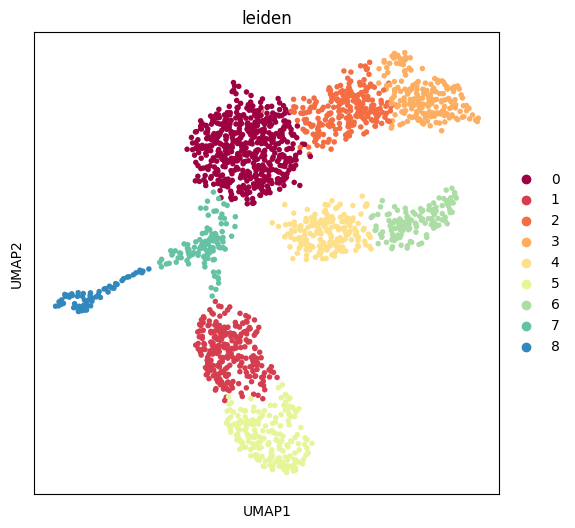

In [3]:
spectral_colors = [
    "#9E0142",  # Dark red
    "#D53E4F",  # Red
    "#F46D43",  # Orange-red
    "#FDAE61",  # Orange
    "#FEE08B",  # Yellow
    "#E6F598",  # Light yellow-green
    "#ABDDA4",  # Light green
    "#66C2A5",  # Green
    "#3288BD",  # Blue
    "#5E4FA2"   # Dark purple
]

fig, axs = plt.subplots(figsize=(6, 6))  # Customize the figure size as needed
sc.pp.neighbors(new_adata)
sc.tl.leiden(new_adata, resolution=1)
sc.pl.umap(new_adata, color=["leiden"], palette=spectral_colors, ax=axs)
#fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_embedding_cluster_UMAP.pdf",  bbox_inches='tight')

In [4]:
datapath = "/mnt/d/BCRdataset/CNS_GSE203552/samples/p1_biopsy"
rawfile_path = os.path.join(datapath, "rna.csv")
rawcount = pd.read_csv(rawfile_path, index_col="barcode")

In [5]:
raw_adata = anndata.AnnData(rawcount)
raw_adata = raw_adata[new_adata.obs.index.tolist()]
raw_adata.obs = new_adata.obs
raw_adata.raw = raw_adata.copy()
sc.pp.filter_cells(raw_adata, min_genes=100)
sc.pp.filter_genes(raw_adata, min_cells=3)
sc.pp.normalize_total(raw_adata)
sc.pp.log1p(raw_adata)
sc.pp.highly_variable_genes(raw_adata, n_top_genes=5000)


/tmp/ipykernel_600385/1094369676.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  raw_adata = anndata.AnnData(rawcount)


In [7]:
raw_adata.obs['celltype_leiden'] = raw_adata.obs['celltypes'].str.cat(raw_adata.obs['leiden'], sep='_')

In [144]:
raw_adata.obs.loc[raw_adata.obs['celltype_leiden'].isin(['mBc2_3', 'mBc2_6']), 'groups'] = 'Group1'
raw_adata.obs.loc[raw_adata.obs['celltype_leiden'].isin(['mBc2_5']), 'groups'] = 'Group2'


In [145]:
temp = raw_adata[raw_adata.obs['groups'].isin(['Group1', 'Group2'])]

In [153]:
temp.obs['groups'].value_counts()

Group1    204
Group2     81
Name: groups, dtype: int64

In [ ]:
temp = raw_adata[raw_adata.obs['celltype_leiden'].isin(['mBc2_3', 'mBc2_6'])]
sc.tl.rank_genes_groups(temp, groupby="celltype_leiden", method='t-test_overestim_var', use_raw=False)
df = sc.get.rank_genes_groups_df(temp, group="mBc2_3")[sc.get.rank_genes_groups_df(temp, group="mBc2_3")['pvals_adj'] < 0.05]

/home/yipingzou2/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


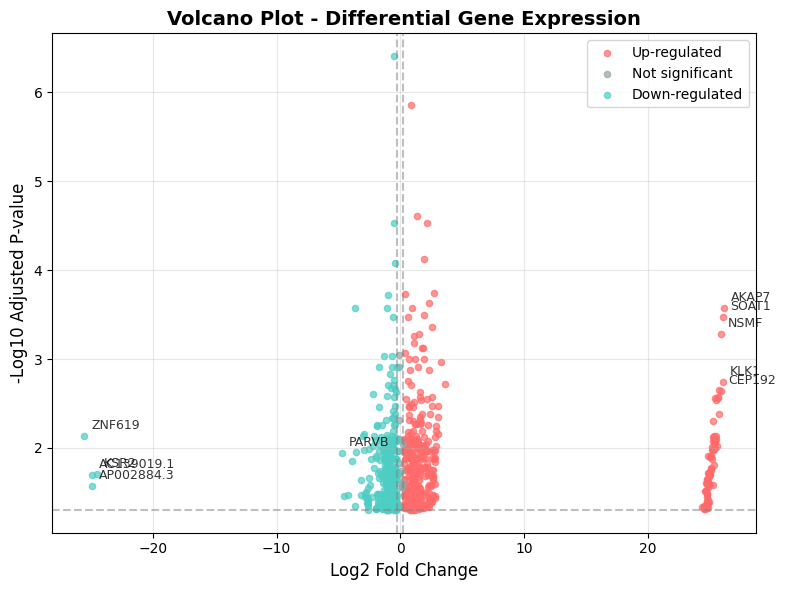

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate -log10(p-value)
df['neg_log10_pval'] = -np.log10(df['pvals_adj'])

# Set thresholds
log_fc_threshold = 0.25  # Log fold change threshold
pval_threshold = 0.05   # P-value threshold
neg_log10_pval_threshold = -np.log10(pval_threshold)

# Classify genes
def classify_genes(row):
    if row['pvals_adj'] < pval_threshold and row['logfoldchanges'] > log_fc_threshold:
        return 'Up-regulated'
    elif row['pvals_adj'] < pval_threshold and row['logfoldchanges'] < -log_fc_threshold:
        return 'Down-regulated'
    else:
        return 'Not significant'

df['regulation'] = df.apply(classify_genes, axis=1)

# Plot volcano plot
plt.figure(figsize=(8, 6))

# Set colors
colors = {'Up-regulated': '#FF6B6B', 'Down-regulated': '#4ECDC4', 'Not significant': '#95A5A6'}

for reg_type in df['regulation'].unique():
    subset = df[df['regulation'] == reg_type]
    plt.scatter(subset['logfoldchanges'], subset['neg_log10_pval'], 
               c=colors[reg_type], label=reg_type, alpha=0.7, s=20)

# Add threshold lines
plt.axhline(y=neg_log10_pval_threshold, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=log_fc_threshold, color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=-log_fc_threshold, color='gray', linestyle='--', alpha=0.5)

# Annotate genes with largest log fold changes
# Get top 5 up-regulated genes with largest logfoldchanges
up_genes = df[df['regulation'] == 'Up-regulated'].nlargest(5, 'logfoldchanges')
# Get top 5 down-regulated genes with smallest logfoldchanges (largest absolute value)
down_genes = df[df['regulation'] == 'Down-regulated'].nsmallest(5, 'logfoldchanges')

# Combine genes to annotate
genes_to_annotate = pd.concat([up_genes, down_genes])

for idx, row in genes_to_annotate.iterrows():
    plt.annotate(row['names'], 
                (row['logfoldchanges'], row['neg_log10_pval']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)

plt.xlabel('Log2 Fold Change', fontsize=12)
plt.ylabel('-Log10 Adjusted P-value', fontsize=12)
plt.title('Volcano Plot - Differential Gene Expression', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/mBc1_5_vs_mBc1_6_subtypes.pdf", 
#             dpi=300, bbox_inches='tight')


Read ST data

In [4]:
# coordinates
coordinates = pd.read_csv("samples/p1_biopsy/coordinates.csv", index_col=0)
STrna = pd.read_csv("samples/p1_biopsy/ST.csv", index_col=0).T
celltypes = pd.read_csv("samples/p1_biopsy/cytospace_results/cell_type_assignments_by_spot.csv", index_col=0)
celltypes['celltypes'] = celltypes.iloc[:, :5].idxmax(axis=1)

coordinates = coordinates.loc[STrna.index.tolist()]
STadata = sc.AnnData(STrna, obsm={"spatial": coordinates[['array_col', 'array_row']].values})
STadata.obs.index.name = "SpotID"
STadata.obs.loc[celltypes.index.tolist(), "celltypes"] = celltypes['celltypes'].values

/home/yipingzou2/.local/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


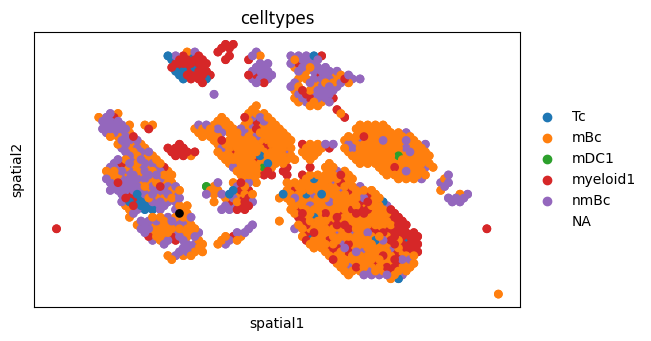

In [5]:

STadata.obs.loc[celltypes.index.tolist(), 'celltypes'] = celltypes['celltypes']
sq.pl.spatial_scatter(STadata, shape=None, color="celltypes")

In [6]:
bcrtype = pd.read_csv("samples/GSE203552_annotation_cluster_bc.csv", index_col=0)
alltype = pd.read_csv("samples/GSE203552_annotation_cluster.csv", index_col=0)

In [ ]:
# coordinates
coordinates = pd.read_csv("samples/p1_biopsy/coordinates.csv", index_col=0)

bcrfile = pd.read_csv("samples/p1_biopsy/processed_bcr.csv", index_col="barcode")
# load cell anotations
bcrtype = pd.read_csv("samples/GSE203552_annotation_cluster_bc.csv", index_col=0)
bcrtype.index.name = "barcode"
# load cell locations
assigned_locations = pd.read_csv("samples/p1_biopsy/cytospace_results/assigned_locations.csv", index_col="OriginalCID")
assigned_locations.index.name = "barcode"

common_cells = list(set(bcrtype.index.tolist()) & set(bcrfile.index.tolist())& set(assigned_locations.index.tolist())& set(new_adata.obs.index.tolist()))
bcrtype = bcrtype.loc[common_cells]
assigned_locations = assigned_locations.loc[common_cells]

assigned_locations.loc[common_cells, 'CellType'] = bcrtype.loc[common_cells]['x']

assigned_locations['leiden'] = new_adata.obs.loc[assigned_locations.index.tolist()].leiden
assigned_locations['array_row'] = coordinates.loc[assigned_locations.SpotID.tolist(), 'array_row'].values
assigned_locations['array_col'] = coordinates.loc[assigned_locations.SpotID.tolist(), 'array_col'].values

print(assigned_locations.head())

                               UniqueCID CellType              SpotID  \
barcode                                                                 
GCGCGATTCAGTACGT-1_p1_biopsy2  UCID12514     mBc3  TTGGACCTATAACAGT-1   
CTTGGCTAGTCCATAC-1_p1_biopsy1  UCID10276     mBc3  CCATGCTCTGCAGGAA-1   
CATTATCTCGACCAGC-1_p1_biopsy2  UCID09062     mBc3  AGCTCTAGACGTTCCA-1   
CCAGCGAGTTTGGGCC-1_p1_biopsy3  UCID07633     mBc3  GTATCTTTCATAACCA-1   
CTGAAGTAGTCTTGCA-1_p1_biopsy3  UCID11828     mBc3  ACAGGCTTGCCCGACT-1   

                               in_tissue  array_row leiden  array_col  
barcode                                                                
GCGCGATTCAGTACGT-1_p1_biopsy2       True         56      4         86  
CTTGGCTAGTCCATAC-1_p1_biopsy1       True         21      0         43  
CATTATCTCGACCAGC-1_p1_biopsy2       True         38      8         76  
CCAGCGAGTTTGGGCC-1_p1_biopsy3       True         46      1         66  
CTGAAGTAGTCTTGCA-1_p1_biopsy3       True         53     

In [8]:
# Specify the cell type to highlight
highlight_celltype = "mBc1"
# Count the occurrences of the specified CellType per SpotID
highlight_counts_mBc1 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()
# Specify the cell type to highlight
highlight_celltype = "mBc3"
# Count the occurrences of the specified CellType per SpotID
highlight_counts_mBc3 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()

share = set(highlight_counts_mBc1.index.tolist()) &  set(highlight_counts_mBc3.index.tolist())
all = set(highlight_counts_mBc1.index.tolist()).union(set(highlight_counts_mBc3.index.tolist()))
print(len(share)/len(all))
print(len(share)/len(highlight_counts_mBc3))
print(len(share)/len(highlight_counts_mBc1))

0.17288135593220338
0.22717149220489977
0.41975308641975306


In [9]:
# Specify the cell type to highlight
highlight_celltype = "mBc1"
# Count the occurrences of the specified CellType per SpotID
highlight_counts_mBc1 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()
# Specify the cell type to highlight
highlight_celltype = "mBc2"
# Count the occurrences of the specified CellType per SpotID
highlight_counts_mBc2 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()

share = set(highlight_counts_mBc1.index.tolist()) &  set(highlight_counts_mBc2.index.tolist())
all = set(highlight_counts_mBc1.index.tolist()).union(set(highlight_counts_mBc2.index.tolist()))
print(len(share)/len(all))
print(len(share)/len(highlight_counts_mBc2))

0.19491525423728814
0.38333333333333336


In [10]:
# Specify the cell type to highlight
highlight_celltype = "mBc2"
# Count the occurrences of the specified CellType per SpotID
highlight_counts_mBc2 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()
# Specify the cell type to highlight
highlight_celltype = "mBc3"
# Count the occurrences of the specified CellType per SpotID
highlight_counts_mBc3 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()

share = set(highlight_counts_mBc3.index.tolist()) &  set(highlight_counts_mBc2.index.tolist())
all = set(highlight_counts_mBc3.index.tolist()).union(set(highlight_counts_mBc2.index.tolist()))
print(len(share)/len(all))
print(len(share)/len(highlight_counts_mBc2))

0.07705479452054795
0.25


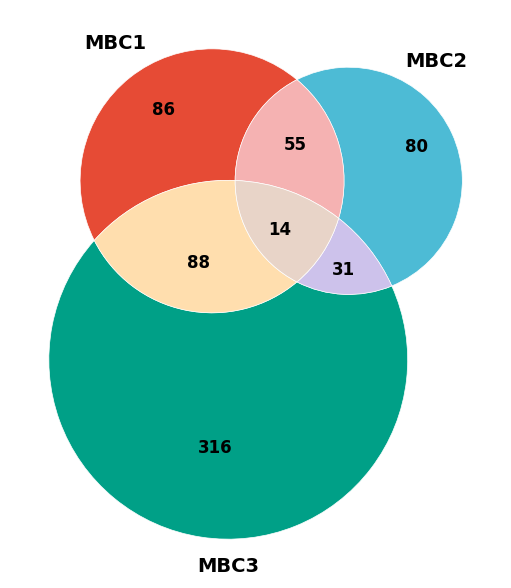

In [57]:
from matplotlib_venn import venn3
from matplotlib.colors import to_rgb, to_hex

# Define light color mixing function
def mix_colors_light(color1, color2, ratio=0.5, lightness=0.3):
    """Mix two colors and increase brightness"""
    rgb1 = np.array(to_rgb(color1))
    rgb2 = np.array(to_rgb(color2))
    mixed = rgb1 * ratio + rgb2 * (1 - ratio)
    # Adjust towards white to increase brightness
    lightened = mixed + (1 - mixed) * lightness
    return to_hex(lightened)

# Original cell type colors
CELL_TYPE_COLORS = {
    'mBc1': '#E64B35',    
    'mBc2': '#4DBBD5',    
    'mBc3': '#00A087',   
}

# Option 2: Preset colors (recommended)
OVERLAP_COLORS_PRESET = {
    'mBc1&mBc2': '#F4A5A5',  # Light pink
    'mBc1&mBc3': '#FFD9A0',  # Light apricot
    'mBc2&mBc3': '#C5B8E8',  # Light purple
    'mBc1&mBc2&mBc3': '#E8D4C8',  # Light beige
}

# Create figure
fig, axs = plt.subplots(figsize=(6, 6))

# Draw Venn diagram
venn = venn3(
    [set(highlight_counts_mBc1.index.tolist()), 
     set(highlight_counts_mBc2.index.tolist()), 
     set(highlight_counts_mBc3.index.tolist())],
    ('MBC1', 'MBC2', 'MBC3')
)

# Set colors - using option 2 (preset colors)
# Individual regions
if venn.get_patch_by_id('100'):
    venn.get_patch_by_id('100').set_color(CELL_TYPE_COLORS['mBc1'])
    venn.get_patch_by_id('100').set_alpha(1)
    venn.get_patch_by_id('100').set_edgecolor('white')
    venn.get_patch_by_id('100').set_linewidth(0.5)

if venn.get_patch_by_id('010'):
    venn.get_patch_by_id('010').set_color(CELL_TYPE_COLORS['mBc2'])
    venn.get_patch_by_id('010').set_alpha(1)
    venn.get_patch_by_id('010').set_edgecolor('white')
    venn.get_patch_by_id('010').set_linewidth(0.5)

if venn.get_patch_by_id('001'):
    venn.get_patch_by_id('001').set_color(CELL_TYPE_COLORS['mBc3'])
    venn.get_patch_by_id('001').set_alpha(1)
    venn.get_patch_by_id('001').set_edgecolor('white')
    venn.get_patch_by_id('001').set_linewidth(0.5)

# Pairwise intersection regions
if venn.get_patch_by_id('110'):
    venn.get_patch_by_id('110').set_color(OVERLAP_COLORS_PRESET['mBc1&mBc2'])
    venn.get_patch_by_id('110').set_alpha(0.85)
    venn.get_patch_by_id('110').set_edgecolor('white')
    venn.get_patch_by_id('110').set_linewidth(0.5)

if venn.get_patch_by_id('101'):
    venn.get_patch_by_id('101').set_color(OVERLAP_COLORS_PRESET['mBc1&mBc3'])
    venn.get_patch_by_id('101').set_alpha(0.85)
    venn.get_patch_by_id('101').set_edgecolor('white')
    venn.get_patch_by_id('101').set_linewidth(0.5)

if venn.get_patch_by_id('011'):
    venn.get_patch_by_id('011').set_color(OVERLAP_COLORS_PRESET['mBc2&mBc3'])
    venn.get_patch_by_id('011').set_alpha(0.85)
    venn.get_patch_by_id('011').set_edgecolor('white')
    venn.get_patch_by_id('011').set_linewidth(0.5)

# Triple intersection region
if venn.get_patch_by_id('111'):
    venn.get_patch_by_id('111').set_color(OVERLAP_COLORS_PRESET['mBc1&mBc2&mBc3'])
    venn.get_patch_by_id('111').set_alpha(1)
    venn.get_patch_by_id('111').set_edgecolor('white')
    venn.get_patch_by_id('111').set_linewidth(0.5)

# Optimize label styles
for text in venn.set_labels:
    if text:
        text.set_fontsize(14)
        text.set_fontweight('bold')

for text in venn.subset_labels:
    if text:
        text.set_fontsize(12)
        text.set_fontweight('bold')

# Adjust layout
plt.tight_layout()
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_mbcs_spotVenn.pdf",  bbox_inches='tight')

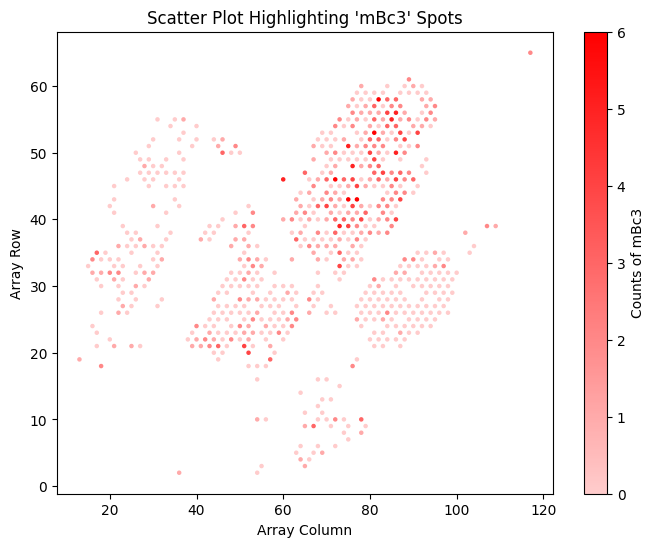

In [18]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# Specify the cell type to highlight
highlight_celltype = "mBc3"

# Count the occurrences of the specified CellType per SpotID
highlight_counts = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)&
                                      (assigned_locations['leiden'] == '0')].groupby('SpotID').size()

# Merge the counts back into the original DataFrame (fill missing spots with 0)
assigned_locations['Highlight'] = assigned_locations['SpotID'].map(highlight_counts).fillna(0)

# Aggregate unique spot positions
spot_positions = assigned_locations.groupby('SpotID')[['array_col', 'array_row', 'Highlight']].first()

# Create a custom red colormap (light red to dark red)
red_cmap = LinearSegmentedColormap.from_list("custom_red", ["#ffcccc", "#ff0000"])  # Light red to dark red

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    spot_positions['array_col'], spot_positions['array_row'], 
    c=spot_positions['Highlight'], 
    cmap=red_cmap,  # Use the custom red colormap
    s=5,  # Keep the size of points constant
)

# Add labels and title
plt.xlabel("Array Column")
plt.ylabel("Array Row")
plt.title(f"Scatter Plot Highlighting '{highlight_celltype}' Spots")
plt.colorbar(scatter, label=f"Counts of {highlight_celltype}")


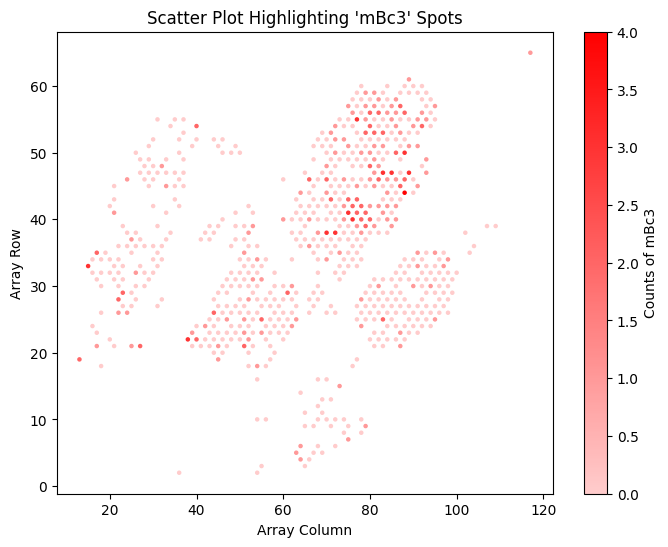

In [20]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# Specify the cell type to highlight
highlight_celltype = "mBc3"

# Count the occurrences of the specified CellType per SpotID
highlight_counts = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)&
                                      (assigned_locations['leiden'] == '1')].groupby('SpotID').size()

# Merge the counts back into the original DataFrame (fill missing spots with 0)
assigned_locations['Highlight'] = assigned_locations['SpotID'].map(highlight_counts).fillna(0)

# Aggregate unique spot positions
spot_positions = assigned_locations.groupby('SpotID')[['array_col', 'array_row', 'Highlight']].first()

# Create a custom red colormap (light red to dark red)
red_cmap = LinearSegmentedColormap.from_list("custom_red", ["#ffcccc", "#ff0000"])  # Light red to dark red

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    spot_positions['array_col'], spot_positions['array_row'], 
    c=spot_positions['Highlight'], 
    cmap=red_cmap,  # Use the custom red colormap
    s=5,  # Keep the size of points constant
)

# Add labels and title
plt.xlabel("Array Column")
plt.ylabel("Array Row")
plt.title(f"Scatter Plot Highlighting '{highlight_celltype}' Spots")
plt.colorbar(scatter, label=f"Counts of {highlight_celltype}")


/tmp/ipykernel_139765/822020628.py:49: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  overlap_data = spots_mbc1.loc[overlapping_spots]


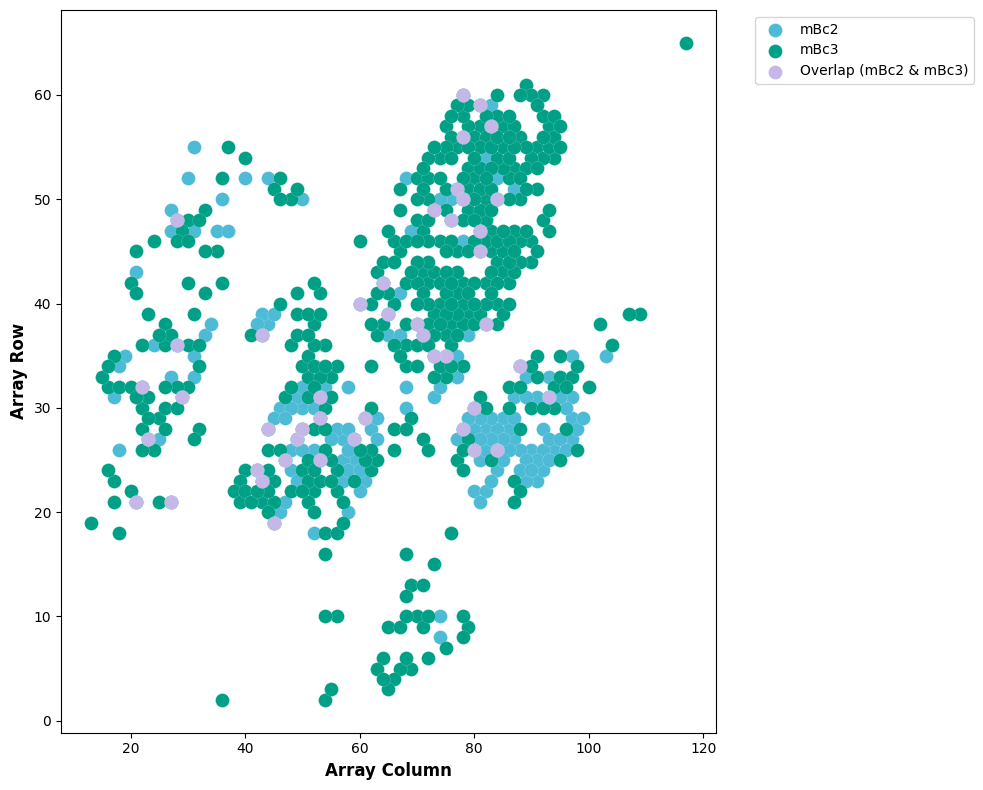

In [56]:
# Specify the cell types
highlight_celltype1 = "mBc2"
highlight_celltype2 = "mBc3"

# Count occurrences
highlight_counts1 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype1)&(assigned_locations['leiden'] == '2')].groupby('SpotID').size()
highlight_counts2 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype2)&(assigned_locations['leiden'] == '3')].groupby('SpotID').size()

# Create separate DataFrames for each cell type
spots_mbc1 = assigned_locations[assigned_locations['CellType'] == highlight_celltype1].groupby('SpotID')[['array_col', 'array_row']].first()
spots_mbc2 = assigned_locations[assigned_locations['CellType'] == highlight_celltype2].groupby('SpotID')[['array_col', 'array_row']].first()

# Find overlapping spots
spots_mbc1['count'] = highlight_counts1
spots_mbc2['count'] = highlight_counts2
overlapping_spots = set(spots_mbc1.index) & set(spots_mbc2.index)

# Use consistent colors from CELL_TYPE_COLORS
CELL_TYPE_COLORS = {
    'mBc2': '#4DBBD5',    # Red (consistent with Venn diagram)
    'mBc3': '#00A087',    # Blue (consistent with Venn diagram)
}

# Overlap color from OVERLAP_COLORS_PRESET
OVERLAP_COLOR = '#C5B8E8'  # Light pink (mBc1&mBc2 overlap)

fig = plt.figure(figsize=(10, 8))

# Plot mBc1 spots
plt.scatter(spots_mbc1['array_col'], spots_mbc1['array_row'],
           c=CELL_TYPE_COLORS['mBc2'],  # Use consistent red
           s=100,
           alpha=1,
           label=f'{highlight_celltype1}',
           edgecolors='white',
           linewidths=0.1)

# Plot mBc2 spots
plt.scatter(spots_mbc2['array_col'], spots_mbc2['array_row'],
           c=CELL_TYPE_COLORS['mBc3'],  # Use consistent blue
           s=100,
           alpha=1,
           label=f'{highlight_celltype2}',
           edgecolors='white',
           linewidths=0.1)

# Highlight overlapping spots
if overlapping_spots:
    overlap_data = spots_mbc1.loc[overlapping_spots]
    plt.scatter(overlap_data['array_col'], overlap_data['array_row'],
               c=OVERLAP_COLOR,  # Use light pink for overlap
               s=100,  # Slightly larger to stand out
               alpha=1,
               label='Overlap (mBc2 & mBc3)',
               edgecolors='white',
               linewidths=0.1)

plt.xlabel("Array Column", fontsize=12, fontweight='bold')
plt.ylabel("Array Row", fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fontsize=10)
plt.tight_layout()
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_embedding_mbc2&mbc3.pdf", bbox_inches='tight', dpi=300)
plt.show()


/tmp/ipykernel_139765/3959422696.py:47: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  overlap_data = spots_mbc1.loc[overlapping_spots]


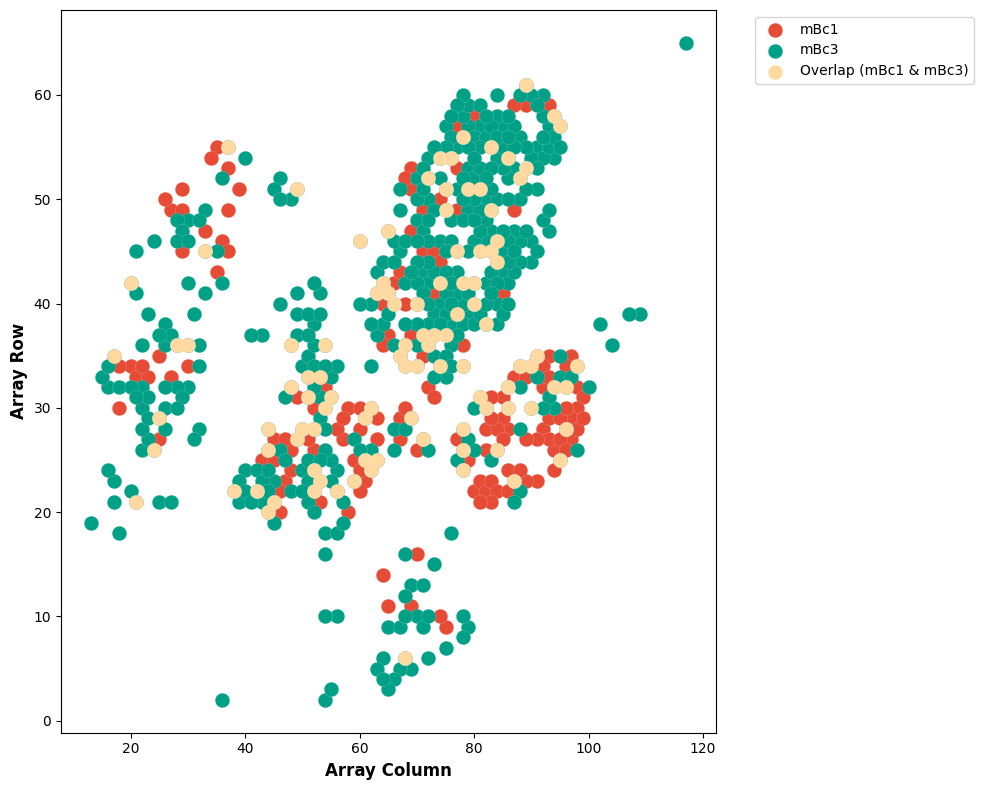

In [52]:
# Specify the cell types
highlight_celltype1 = "mBc1"
highlight_celltype2 = "mBc3"

# Count occurrences
highlight_counts1 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype1)&(assigned_locations['leiden'] == '2')].groupby('SpotID').size()
highlight_counts2 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype2)&(assigned_locations['leiden'] == '3')].groupby('SpotID').size()

# Create separate DataFrames for each cell type
spots_mbc1 = assigned_locations[assigned_locations['CellType'] == highlight_celltype1].groupby('SpotID')[['array_col', 'array_row']].first()
spots_mbc2 = assigned_locations[assigned_locations['CellType'] == highlight_celltype2].groupby('SpotID')[['array_col', 'array_row']].first()

# Find overlapping spots
spots_mbc1['count'] = highlight_counts1
spots_mbc2['count'] = highlight_counts2
overlapping_spots = set(spots_mbc1.index) & set(spots_mbc2.index)

# Use consistent colors from CELL_TYPE_COLORS
CELL_TYPE_COLORS = {
    'mBc1': '#E64B35',    # Red (consistent with Venn diagram)
    'mBc3': '#00A087',    # Blue (consistent with Venn diagram)
}

# Overlap color from OVERLAP_COLORS_PRESET
OVERLAP_COLOR = '#FFD9A0'  # Light pink (mBc1&mBc2 overlap)

fig = plt.figure(figsize=(10, 8))

# Plot mBc1 spots
plt.scatter(spots_mbc1['array_col'], spots_mbc1['array_row'],
           c=CELL_TYPE_COLORS['mBc1'],  # Use consistent red
           s=110,
           label=f'{highlight_celltype1}',
           edgecolors='white',
           linewidths=0.1)

# Plot mBc2 spots
plt.scatter(spots_mbc2['array_col'], spots_mbc2['array_row'],
           c=CELL_TYPE_COLORS['mBc3'],  # Use consistent blue
           s=110,
           label=f'{highlight_celltype2}',
           edgecolors='white',
           linewidths=0.1)

# Highlight overlapping spots
if overlapping_spots:
    overlap_data = spots_mbc1.loc[overlapping_spots]
    plt.scatter(overlap_data['array_col'], overlap_data['array_row'],
               c=OVERLAP_COLOR,  # Use light pink for overlap
               s=110,  # Slightly larger to stand out
               label='Overlap (mBc1 & mBc3)',
               edgecolors='white',
               linewidths=0.1)

plt.xlabel("Array Column", fontsize=12, fontweight='bold')
plt.ylabel("Array Row", fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fontsize=10)
plt.tight_layout()
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_embedding_mbc1&mbc3.pdf", bbox_inches='tight', dpi=300)
plt.show()


/tmp/ipykernel_139765/3720308543.py:49: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  overlap_data = spots_mbc1.loc[overlapping_spots]


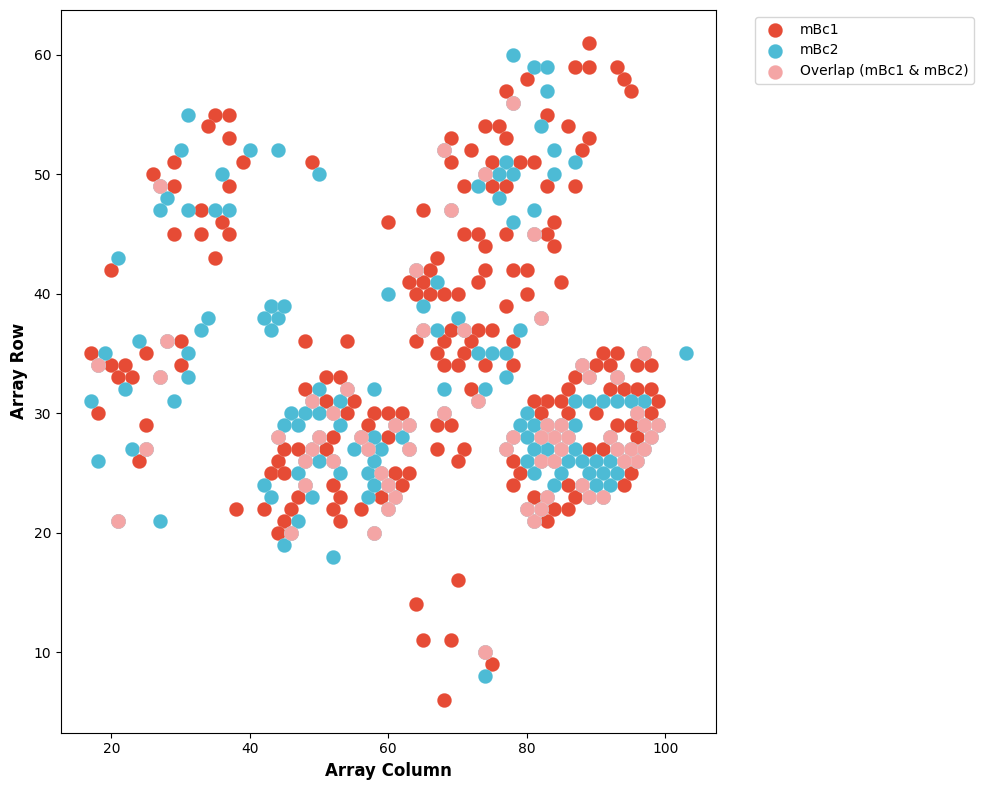

In [48]:
# Specify the cell types
highlight_celltype1 = "mBc1"
highlight_celltype2 = "mBc2"

# Count occurrences
highlight_counts1 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype1)&(assigned_locations['leiden'] == '2')].groupby('SpotID').size()
highlight_counts2 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype2)&(assigned_locations['leiden'] == '3')].groupby('SpotID').size()

# Create separate DataFrames for each cell type
spots_mbc1 = assigned_locations[assigned_locations['CellType'] == highlight_celltype1].groupby('SpotID')[['array_col', 'array_row']].first()
spots_mbc2 = assigned_locations[assigned_locations['CellType'] == highlight_celltype2].groupby('SpotID')[['array_col', 'array_row']].first()

# Find overlapping spots
spots_mbc1['count'] = highlight_counts1
spots_mbc2['count'] = highlight_counts2
overlapping_spots = set(spots_mbc1.index) & set(spots_mbc2.index)

# Use consistent colors from CELL_TYPE_COLORS
CELL_TYPE_COLORS = {
    'mBc1': '#E64B35',    # Red (consistent with Venn diagram)
    'mBc2': '#4DBBD5',    # Blue (consistent with Venn diagram)
}

# Overlap color from OVERLAP_COLORS_PRESET
OVERLAP_COLOR = '#F4A5A5'  # Light pink (mBc1&mBc2 overlap)

fig = plt.figure(figsize=(10, 8))

# Plot mBc1 spots
plt.scatter(spots_mbc1['array_col'], spots_mbc1['array_row'],
           c=CELL_TYPE_COLORS['mBc1'],  # Use consistent red
           s=110,
           alpha=1,
           label=f'{highlight_celltype1}',
           edgecolors='white',
           linewidths=0.1)

# Plot mBc2 spots
plt.scatter(spots_mbc2['array_col'], spots_mbc2['array_row'],
           c=CELL_TYPE_COLORS['mBc2'],  # Use consistent blue
           s=110,
           alpha=1,
           label=f'{highlight_celltype2}',
           edgecolors='white',
           linewidths=0.1)

# Highlight overlapping spots
if overlapping_spots:
    overlap_data = spots_mbc1.loc[overlapping_spots]
    plt.scatter(overlap_data['array_col'], overlap_data['array_row'],
               c=OVERLAP_COLOR,  # Use light pink for overlap
               s=110,  # Slightly larger to stand out
               alpha=1,
               label='Overlap (mBc1 & mBc2)',
               edgecolors='white',
               linewidths=0.1)

plt.xlabel("Array Column", fontsize=12, fontweight='bold')
plt.ylabel("Array Row", fontsize=12, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=True, fontsize=10)
plt.tight_layout()
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p1_embedding_mbc1&mbc2.pdf", bbox_inches='tight', dpi=300)
plt.show()


## p2

         Falling back to preprocessing with `sc.pp.pca` and default params.


/tmp/ipykernel_1411304/2427470644.py:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  new_adata = anndata.AnnData(embeddings)
/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


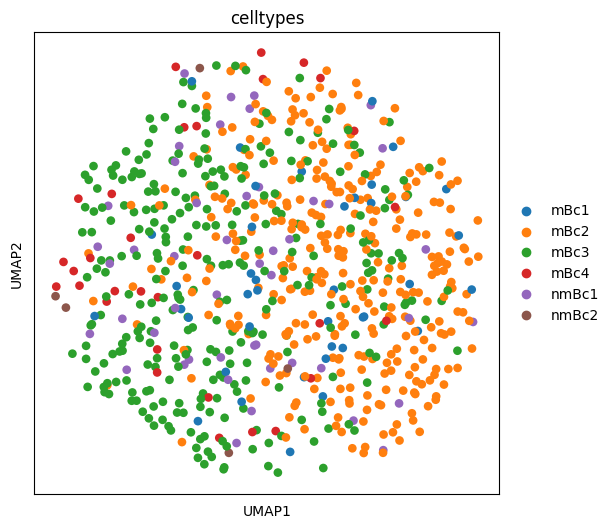

In [42]:
bcrtype = pd.read_csv("samples/GSE203552_annotation_cluster_bc.csv", index_col=0)
bcrtype.index.name = "barcode"

biopsy = pd.read_csv("samples/p2_biopsy/processed_bcr.csv", index_col="barcode")
bcremb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/CNS_GSE203552/p2_biopsy/mean_inner01.pth/embedding.csv").values
gexemb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/CNS_GSE203552/p2_biopsy/mean_inner01.pth/gexembedding.csv").values
datapath = "/mnt/d/BCRdataset/CNS_GSE203552/samples/p2_biopsy"
bcrfile_path = os.path.join(datapath, "processed_bcr.csv")
bcrfile = pd.read_csv(bcrfile_path, index_col="barcode")
bcrfile['whole_seq'] = bcrfile['fwr1'].str.cat([bcrfile["cdr1"], bcrfile["cdr2"], bcrfile["fwr2"], bcrfile["cdr2"], bcrfile["fwr3"],
                                               bcrfile["cdr3"], bcrfile["fwr4"]])
embeddings = np.concatenate([bcremb, gexemb], axis=1)
embeddings = torch.from_numpy(embeddings)
embeddings = F.normalize(embeddings, dim = -1).numpy()


new_adata = anndata.AnnData(embeddings)
new_adata.obs['barcode'] = bcrfile.index.tolist()
new_adata.obs = new_adata.obs.set_index('barcode', inplace=False)
new_adata.obs['cdr3'] = biopsy.cdr3.tolist()
common_cells = list(set(bcrtype.index.tolist()) & set(biopsy.index.tolist()))
new_adata.obs.loc[common_cells, 'celltypes'] = bcrtype.loc[common_cells].values
new_adata = new_adata[new_adata.obs[new_adata.obs.celltypes.isin(["mBc1", "mBc2", "mBc3", "mBc4", "nmBc1", "nmBc2"])].index.tolist()]
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(new_adata)

fig, axs = plt.subplots(figsize=(6, 6))  # Customize the figure size as needed
sc.pl.umap(new_adata, color="celltypes", ax=axs)
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p2_embedding_UMAP.pdf",  bbox_inches='tight')

/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


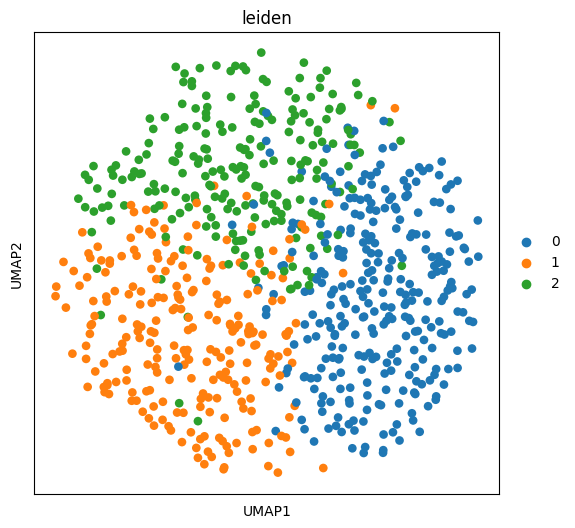

In [43]:
fig, axs = plt.subplots(figsize=(6, 6))
sc.tl.leiden(new_adata, resolution=0.6)
sc.pl.umap(new_adata, color=["leiden"], ax=axs)
#fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p2_embedding_cluster_UMAP.pdf",  bbox_inches='tight')

In [5]:
bcrtype = pd.read_csv("samples/GSE203552_annotation_cluster_bc.csv", index_col=0)
bcrfile = pd.read_csv("samples/p2_biopsy/processed_bcr.csv", index_col="barcode")
# load cell anotations
bcrtype = pd.read_csv("samples/GSE203552_annotation_cluster_bc.csv", index_col=0)
bcrtype.index.name = "barcode"
# load cell locations
assigned_locations = pd.read_csv("samples/p2_biopsy/cytospace_results/assigned_locations.csv", index_col="OriginalCID")
assigned_locations.index.name = "barcode"
# load ST coordinates
coordinates = pd.read_csv("samples/p2_biopsy/coordinates.csv", index_col=0)

common_cells = list(set(bcrtype.index.tolist()) & set(bcrfile.index.tolist())& set(assigned_locations.index.tolist()))
bcrtype = bcrtype.loc[common_cells]
assigned_locations = assigned_locations.loc[common_cells]

assigned_locations.loc[common_cells, 'CellType'] = bcrtype.loc[common_cells]['x']
assigned_locations['leiden'] = new_adata.obs.loc[assigned_locations.index.tolist()].leiden
assigned_locations['array_row'] = coordinates.loc[assigned_locations.SpotID.tolist(), 'array_row'].values
assigned_locations['array_col'] = coordinates.loc[assigned_locations.SpotID.tolist(), 'array_col'].values

print(assigned_locations.head())

                              UniqueCID CellType              SpotID  \
barcode                                                                
ACCAAACGTGGATGAC-1_p2_biopsy  UCID07179     mBc3  CGCTGTGTGGATGTTG-1   
TTTGACTCAACCCTAA-1_p2_biopsy  UCID10101     mBc2  ACTCTTGTATAGTAAC-1   
TCATTCAGTTGAAGTA-1_p2_biopsy  UCID12123      NaN  TGTACGAACAAATCCG-1   
TCATTCAGTTGAAGTA-1_p2_biopsy  UCID13223      NaN  TGTACGAACAAATCCG-1   
TCATTCAGTTGAAGTA-1_p2_biopsy  UCID14038      NaN  TGTACGAACAAATCCG-1   

                              in_tissue  array_row leiden  array_col  
barcode                                                               
ACCAAACGTGGATGAC-1_p2_biopsy       True         59      2         43  
TTTGACTCAACCCTAA-1_p2_biopsy       True         36      1         70  
TCATTCAGTTGAAGTA-1_p2_biopsy       True         38      0         58  
TCATTCAGTTGAAGTA-1_p2_biopsy       True         38      0         58  
TCATTCAGTTGAAGTA-1_p2_biopsy       True         38      0         58 

In [6]:
# Specify the cell type to highlight
highlight_celltype = "mBc1"
# Count the occurrences of the specified CellType per SpotID
highlight_counts_mBc1 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()
# Specify the cell type to highlight
highlight_celltype = "mBc2"
# Count the occurrences of the specified CellType per SpotID
highlight_counts_mBc2 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()
# Specify the cell type to highlight
highlight_celltype = "mBc3"
# Count the occurrences of the specified CellType per SpotID
highlight_counts_mBc3 = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()

share = set(highlight_counts_mBc3.index.tolist()) &  set(highlight_counts_mBc1.index.tolist())
all = set(highlight_counts_mBc3.index.tolist()).union(set(highlight_counts_mBc1.index.tolist()))
print(len(share)/len(all))
print(len(share)/len(highlight_counts_mBc1))
print(len(share)/len(highlight_counts_mBc3))

share = set(highlight_counts_mBc2.index.tolist()) &  set(highlight_counts_mBc1.index.tolist())
all = set(highlight_counts_mBc2.index.tolist()).union(set(highlight_counts_mBc1.index.tolist()))
print(len(share)/len(all))
print(len(share)/len(highlight_counts_mBc1))
print(len(share)/len(highlight_counts_mBc2))

share = set(highlight_counts_mBc3.index.tolist()) &  set(highlight_counts_mBc2.index.tolist())
all = set(highlight_counts_mBc3.index.tolist()).union(set(highlight_counts_mBc2.index.tolist()))
print(len(share)/len(all))
print(len(share)/len(highlight_counts_mBc2))
print(len(share)/len(highlight_counts_mBc3))

0.10185185185185185
0.4074074074074074
0.11956521739130435
0.11818181818181818
0.48148148148148145
0.13541666666666666
0.22875816993464052
0.3645833333333333
0.3804347826086957


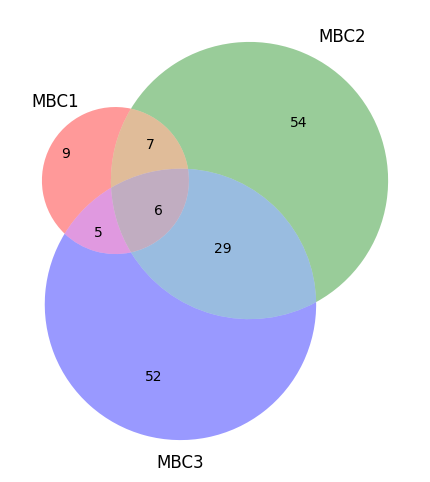

In [7]:
from matplotlib_venn import venn3
fig, axs = plt.subplots(figsize=(6, 6))
venn = venn3([set(highlight_counts_mBc1.index.tolist()), set(highlight_counts_mBc2.index.tolist()), set(highlight_counts_mBc3.index.tolist())],
             ('MBC1', 'MBC2', 'MBC3'))
# Customize the figure size as needed
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p2_mbcs_spotVenn.pdf",  bbox_inches='tight')

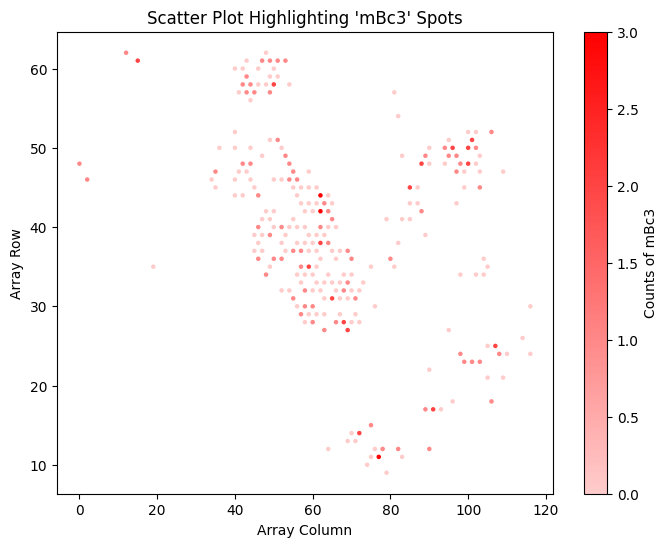

In [12]:
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

# Specify the cell type to highlight
highlight_celltype = "mBc3"

# Count the occurrences of the specified CellType per SpotID
highlight_counts = assigned_locations[(assigned_locations['CellType'] == highlight_celltype)].groupby('SpotID').size()

# Merge the counts back into the original DataFrame (fill missing spots with 0)
assigned_locations['Highlight'] = assigned_locations['SpotID'].map(highlight_counts).fillna(0)

# Aggregate unique spot positions
spot_positions = assigned_locations.groupby('SpotID')[['array_col', 'array_row', 'Highlight']].first()

# Create a custom red colormap (light red to dark red)
red_cmap = LinearSegmentedColormap.from_list("custom_red", ["#ffcccc", "#ff0000"])  # Light red to dark red

# Create a scatter plot
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    spot_positions['array_col'], spot_positions['array_row'], 
    c=spot_positions['Highlight'], 
    cmap=red_cmap,  # Use the custom red colormap
    s=5,  # Keep the size of points constant
)

# Add labels and title
plt.xlabel("Array Column")
plt.ylabel("Array Row")
plt.title(f"Scatter Plot Highlighting '{highlight_celltype}' Spots")
plt.colorbar(scatter, label=f"Counts of {highlight_celltype}")

# Show the plot
plt.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p2_embedding_mbc3.pdf",  bbox_inches='tight')

Read ST data

In [87]:
# coordinates
coordinates = pd.read_csv("samples/p2_biopsy/coordinates.csv", index_col=0)
STrna = pd.read_csv("samples/p2_biopsy/ST.csv", index_col=0).T
celltypes = pd.read_csv("samples/p2_biopsy/cytospace_results/cell_type_assignments_by_spot.csv", index_col=0)
celltypes['celltypes'] = celltypes.iloc[:, :5].idxmax(axis=1)

coordinates = coordinates.loc[STrna.index.tolist()]
STadata = sc.AnnData(STrna, obsm={"spatial": coordinates[['array_col', 'array_row']].values})
STadata.obs.index.name = "SpotID"

/tmp/ipykernel_1947833/1910492538.py:8: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  STadata = sc.AnnData(STrna, obsm={"spatial": coordinates[['array_col', 'array_row']].values})


/home/yipingzou2/.local/lib/python3.8/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


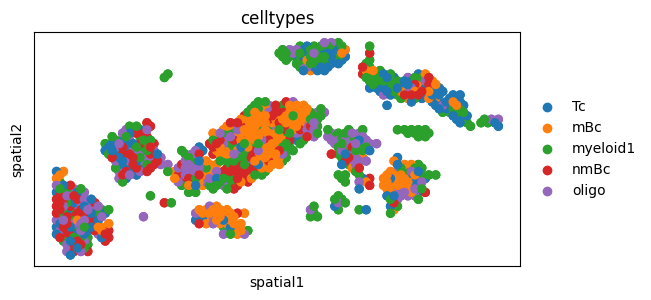

In [88]:
STadata.obs.loc[celltypes.index.tolist(), 'celltypes'] = celltypes['celltypes']
sq.pl.spatial_scatter(STadata, shape=None, color="celltypes")

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/yipingzou2/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/yipingzou2/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


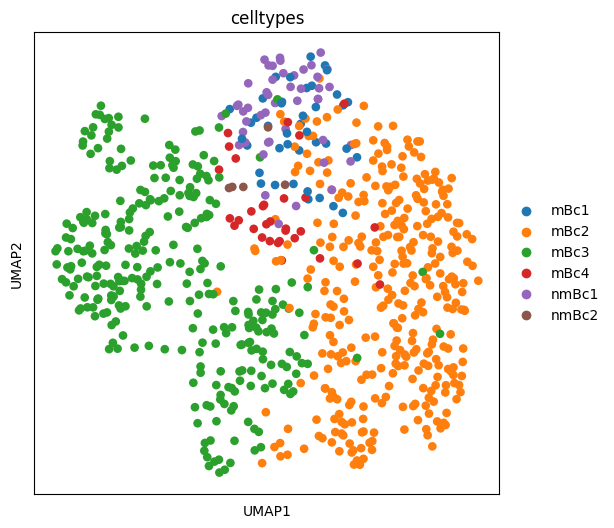

In [40]:
bcrtype = pd.read_csv("samples/GSE203552_annotation_cluster_bc.csv", index_col=0)
bcrtype.index.name = "barcode"

adata = anndata.read_csv("samples/p2_biopsy/processed_rna.csv")
biopsy = pd.read_csv("samples/p2_biopsy/processed_bcr.csv", index_col="barcode")
common_cells = list(set(bcrtype.index.tolist()) & set(biopsy.index.tolist()))
adata.obs.loc[common_cells, 'celltypes'] = bcrtype.loc[common_cells].values
adata = adata[adata.obs[adata.obs.celltypes.isin(["mBc1", "mBc2", "mBc3", "mBc4", "nmBc1", "nmBc2"])].index.tolist()]
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)
#sc.pp.highly_variable_genes(adata, n_top_genes=5000)
#adata = adata[:, adata.var.highly_variable]
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(adata)

fig, axes = plt.subplots(figsize=(6, 6))  # Customize the figure size as needed
sc.pl.umap(adata, color="celltypes", ax=axes)
fig.savefig("/mnt/d/unifiedBCR/figures/CNS_GSE203552/p2_original_UMAP.pdf",  bbox_inches='tight')